# Pharmacokinetics and Pharmacodynamics of Myelotoxicity

### Contents
- [Introduction](1_introduction.ipynb)
- [The Forward Model](2_forward_model.ipynb)
- [Exploring Data](3_data_explore.ipynb)
- **Parameter Inference**
    - [Maximum Likelihood](#Maximum-Likelihood)
        - [Maximum Likelihood PK](#Maximum-Likelihood-PK)
        - [Maximum Likelihood PD](#Maximum-Likelihood-PD)
    - [Bayesian Inference](#Bayesian-Inference)
        - [Bayesian Inference Pk](#Bayesian-Inference-PK)
        - [Bayesian Inference PD](#Bayesian-Inference-PD)
- [Parameter Identifiability](5_parameter_identifiability_naive.ipynb)
- [Model Selection](PD_naive_pooled_inference.ipynb)

In [1]:
import pandas
import pints
import pints.plot
import pints.io
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from Code.PK_model import PintsPKLinIV as Pints_PK_model
from Code.PD_model import PintsPDFribergLinE as Pints_PD_model
from Code.Likelihoods import MultiplicativeGaussianLogLikelihood, GaussianLogLikelihood, ConstantAndMultiplicativeGaussianLogLikelihood


In [2]:
image_file = "../Images/parameter_inference/"
drug = 'Docetaxel'
num_PK_comp = 2
observation_name = 'Platelets '

## Parameter Inference

As seen in section \ref{section:forward-model}, the forward problem comes naturally: given a model and a set of parameters, $\theta = \left(CL, Q_d, K_\textrm{tr}, slope, \ldots\right)$, what is the resulting time-profiles of the variables. However, the model and parameters that best describe actuality are not known, but the resulting time-profiles (of particular variables, at certain time points, of a sample of individuals) are known. This describes the reverse problem: given a data-set, which model and set of parameters can best describe the observations. To solve this reverse problem, parameter inference and model selection needs to be carried out. Then, after the reverse problem has been solved, we can explore the forward problem to make predictions on the effects of differing doses.

### Maximum Likelihood

A common approach to parameter inference is to maximise the probability the data, $X^\textrm{obs}$, was generated by the model with parameters, $\theta \in \Theta$, over the parameter space $\Theta$. This probability, $P\left(X^\textrm{obs}|\theta\right)$, is called the likelihood and can be calculated as the product of point-wise likelihoods,
\begin{equation*}
P\left(X^\textrm{obs}|\theta\right) = \prod_{x^{obs}_i \in X^\textrm{obs}} P\left(x^{obs}_i|\theta\right).
\end{equation*}
Alternatively, a computationally easier but equivalent optimisation is the log-likelihood,
\begin{equation*}
\log\left(P\left(X^\textrm{obs}|\theta\right)\right) = \sum_{x^{obs}_i \in X^\textrm{obs}} \log\left(P\left(x^{obs}_i|\theta\right)\right).
\end{equation*}

There are 12 parameters to find in the Friberg PKPD model: $k_0$, $k_1$, $V_c$, $V_1$, $\sigma_\textrm{rel, PK}$, $C_{\textrm{cell,}0}$, MTT, $\gamma$, $s$, $\sigma_\textrm{base,PD}$, $\sigma_\textrm{rel,PD}$ and $\eta_\textrm{PD}$. This means there is a 12-dimensional parameter space to search. However to speed up the searching, I have split this into two problems, the PK problem and the PD problem. The PK problem optimises the likelihood $P\left(X^\textrm{obs}_\textrm{PK}|\theta_\textrm{PK}, \sigma_c\right)$, over the 5-dimensional parameter space $\Theta_\textrm{PK}$, with $\theta_\textrm{PK} = \left(k_0, k_1, V_c, V_1, \sigma_\textrm{rel,PK}\right) \in \Theta_\textrm{PK}$ and given the drug concentration over time data, $X^\textrm{obs}_\textrm{PK}$. The PD problem optimises the likelihood $P\left(X^\textrm{obs}_\textrm{PD}|\theta_\textrm{PD}, \sigma_c\right)$, over the 7-dimensional parameter space $\Theta_\textrm{PD}$, with $\theta_\textrm{PD} = \left(C_\textrm{cell, }0, \textrm{MTT}, \gamma, s, \sigma_\textrm{base,PD}, \sigma_\textrm{rel,PD}, \eta_\textrm{PD}\right) \in \Theta_\textrm{PD}$ and given the blood cell concentration over time data, $X^\textrm{obs}_\textrm{PD}$. The PD problem would use the PK parameters fixed to the optimum found.

#### Maximum Likelihood PK
To find the optimum of these likelihoods I used the CMA-ES (Covariance Matrix Adaptation Evolution Strategy) algorithm to search the parameter space, implemented by the PINTS package for python\cite{PINTS}. This searching algorithm works by having a population of points, $Y^{\left(g\right)} \subset \Theta$, and iteratively generating new populations based on the output of the objective function, the function to optimise, at the points in the previous population. This new population, $Y^{\left(g+1\right)}$, is selected using a normal distribution based on the covariance matrix: 
        \begin{equation*}
            \theta_k^{\left(g+1\right)} = \mathbf{m}^{\left(g\right)} + h^{\left(g\right)}\mathbf{\nu}_k, \hspace{20 mm} \forall \theta_k^{\left(g+1\right)} \in Y^{\left(g+1\right)},
        \end{equation*}
        where $\nu_k \sim \mathcal{N}\left(\mathbf{0},\,\mathbf{C}^{\left(g\right)}\right)$; $\mathbf{m}^{\left(g\right)} = \sum_{\theta_x \in B^{\left(g\right)}} w_x \theta_x$, a weighted average over the subset $B^{\left(g\right)} \subset Y^{\left(g\right)}$ of the best points in the sample according to our objective function. The weights are such that the points in the population are weighted more highly; $h^{\left(g\right)}$ is the step size that is adapted at each iteration; and $\mathbf{C}^{\left(g\right)}$ is an estimation of the covariance matrix using the $g$th and $\left(g-1\right)$th population. \cite{Hansen2016}

**Results on the Simulated data**

In [3]:
df = pandas.read_csv("../Data_and_parameters/PK_sim/sythesised_data_real_timepoints.csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
dose_amount = df.DOSE.mean() # mg
dose_unit = "mg"
print(df)

print("Average dose amount = " + str(dose_amount))

        ID  DOSE   TIME       OBS
0    100.0   1.0  0.083  0.786371
1    100.0   1.0  0.333  0.150120
2    100.0   1.0  2.500  0.024490
3    100.0   1.0  4.666  0.014349
4    100.0   1.0  4.833  0.013990
..     ...   ...    ...       ...
265  314.0   3.0  0.333  0.458085
266  314.0   3.0  2.500  0.073334
267  314.0   3.0  4.666  0.038128
268  314.0   3.0  4.833  0.036075
269  314.0   3.0  5.000  0.041486

[270 rows x 4 columns]
Average dose amount = 2.0


In [4]:
# Before starting the optimisation we should estimate the parameter Vol_C. We can do this by drawing a line 
# through the first 2 points and seeing where it crosses the y-axis
df['rank'] = df.sort_values('TIME').groupby('ID').cumcount()+1
first_points = df[df['rank'] == 1].sort_values('ID', ignore_index=True)
second_points = df[df['rank'] == 2].sort_values('ID', ignore_index=True)

y_0 = first_points['OBS'] - first_points['TIME'] * (
    (first_points['OBS'] - second_points['OBS'])
    / (first_points['TIME'] - second_points['TIME'])
)
Vol_C_approx = (first_points['DOSE']/y_0).mean()
print("Aproximate V_C:")
print(Vol_C_approx)

Aproximate V_C:
1.029204388130112


In [5]:
PK_actual_params = np.load("../Data_and_parameters/PK_sim/actual_params.npy")
PK_param_names = PK_actual_params[0, :]
PK_actual_params = PK_actual_params[1, :].astype('float64')

PK_model = Pints_PK_model(data=df, num_comp=2)
pseudo_times = PK_model.pseudotime
problem = pints.SingleOutputProblem(PK_model, pseudo_times, df['OBS'].to_numpy())
log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
error_measure = pints.ProbabilityBasedError(log_likelihood)
lower_bound = [0.1*Vol_C_approx, 0.01, 0.01*Vol_C_approx, 0.01, 0.0001]
upper_bound = [10*Vol_C_approx, 100, 100*Vol_C_approx, 100, 1]
start_point = np.exp((np.log(lower_bound)+np.log(upper_bound))*0.5)

In [6]:
# Optimise the model with respect to the data
optimisation = pints.OptimisationController(error_measure, start_point, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()
time = optimisation.time()

print('Result:\t'+str(parameters))
print('Error: \t'+str(error))
print('Time Taken: \t'+str(int(time/60))+" minutes, "+str(int(time%60))+" seconds, ")

Result:	[0.70646743 2.8364916  4.85437753 2.36517131 0.08987315]
Error: 	-961.1563673110426
Time Taken: 	11 minutes, 27 seconds, 


In [6]:
# np.save('../Data_and_parameters/PK_sim/opt_'+str(drug), parameters)
parameters = np.load('../Data_and_parameters/PK_sim/opt_'+str(drug)+'.npy')

In [8]:
# Create the Data
dose_amts = df.DOSE.unique()
x_label = "Time, hours"
y_label = "Drug concentration,<br>mg/L"
col_label = 'Dose, '+dose_unit
df_graph = df.rename(columns={
    'DOSE':col_label, 
    'TIME':x_label, 
    'OBS':y_label
}, errors="raise")
df_graph = df_graph.astype({col_label: 'category'}, errors="raise")

time_span = df["TIME"].max()
more_times = np.linspace(0,time_span,1000)

# Visualise the data
fig = px.scatter(
    df_graph,
    x=x_label,
    y=y_label,
    color = col_label,
    width=500, 
    height=360,
    color_discrete_sequence=px.colors.qualitative.Plotly[1:],
    hover_data=list(df_graph.columns)
)


for i, amt in enumerate(dose_amts[:]):
    
    more_values = PK_model.single_simulate(parameters[:-1], more_times, amt)
    fig.add_trace(
        go.Scatter(
            x=more_times,
            y=more_values,
            legendgroup=amt,
            showlegend= False,
            mode="lines",
            line=go.scatter.Line(color=px.colors.qualitative.Plotly[i+1]),
        ), 
    )
    true_values = PK_model.single_simulate(PK_actual_params[:-1], more_times, amt)
    fig.add_trace(
        go.Scatter(
            x=more_times,
            y=true_values,
            legendgroup=amt,
            showlegend= False,
            mode="lines",
            line=go.scatter.Line(color=px.colors.qualitative.Plotly[i+1],
                              dash='dash'),
        ), 
    )
#     fig.add_trace(
#         go.Scatter(
#             x=np.concatenate((more_times, more_times[::-1])),
#             y=np.concatenate((
#                 more_values*(1+parameters[-1]), 
#                 more_values[::-1]*(1-parameters[-1])
#             )),
#             legendgroup=amt,
#             showlegend= False,
#             marker = dict(color=px.colors.qualitative.Plotly[i+1]),
#             fill='toself',
#             mode='lines',
#             line=dict(width=0),
#         ), 
#     )
fig.add_trace(go.Scatter(
        x=[0],
        y=[0],
        legendgroup="Group",
        showlegend= True,
        legendgrouptitle_text=" ",
        mode="markers",
        marker = dict(color="black"),
        name='Observed<br>values',
    ))
fig.add_trace(go.Scatter(
        x=[0],
        y=[0],
        legendgroup="Group",
        showlegend= True,
        mode="lines",
        line=go.scatter.Line(color="black"),
        name="Prediction"))
fig.add_trace(go.Scatter(
        x=[0],
        y=[0],
        legendgroup="Group",
        showlegend= True,
        mode="lines",
        line=go.scatter.Line(color='black',
                          dash='dash'),
        name='Simulation with<br>true parameters'))
# fig.add_trace(go.Scatter(
#         x=[0],
#         y=[0],
#         legendgroup="Group",
#         showlegend= True,
#         marker = dict(color="black"),
#         fill='toself',
#         mode='lines',
#         line=dict(width=0),
#         name="Noise<br>Prediction"))


y_range = [np.log10(np.min(df_graph[y_label]))-0.05, np.log10(np.max(df_graph[y_label]))+0.2]
fig['layout']['yaxis'].update(type="log", minor=dict(dtick='D1', showgrid=True), dtick = 1, range=y_range)
fig.show()

# fig.write_image(image_file + "PK_sim_opt_graph.svg")

In [9]:
summary_data = np.transpose(np.array([PK_param_names, np.round(parameters, 4), np.round(PK_actual_params, 4)]))
summary_df = pandas.DataFrame(summary_data, columns = ['Parameter', 'Optimised', 'True'])
# summary_df.to_csv("../Data_and_parameters/PK_sim/opt_results.csv")

fig =  ff.create_table(summary_df)
fig.update_layout(
    width=250,
    height=175,
)
# fig.write_image(image_file + "PK_sim_opt_table.svg")
fig.show()

**Results on Experimental Data**

In [11]:
df = pandas.read_csv("../Data_and_parameters/PK_real/data_refined_Docetaxel.csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
print(df)

unit = "ng/mL"
df = df.astype({'OBS': 'float64'})
df['OBS'] = df["OBS"]/1000  # Converting from ng/ml to mg/l

# Get actual dose amount
patient_info = pandas.read_csv("../Data_and_parameters/patient_details_refined_Docetaxel.csv")
patient_info = patient_info.loc[patient_info['ID'].isin(df.ID)].sort_values('ID', ignore_index=True)
print(patient_info)
dose_amount = patient_info.AMT.mean() # mg
dose_unit = "mg"
print("Average dose amount = " + str(dose_amount))

       ID  DOSE    TIME      OBS
0    5335   5.0   0.083  320.827
1    5335   5.0   1.167   19.586
2    5335   5.0   3.333   13.028
3    5335   5.0   4.250   12.074
4    5335   5.0   4.833   12.356
..    ...   ...     ...      ...
103  5370  15.0   0.416  462.413
104  5370  15.0   1.666  100.467
105  5370  15.0   3.333   45.856
106  5370  15.0   7.833   14.541
107  5370  15.0  10.000    6.640

[108 rows x 4 columns]
      ID  DOSE   WT  AMT       WTM
0   5335   5.0  0.2  1.0  0.999198
1   5336   5.0  0.2  1.0  0.999198
2   5337   5.0  0.2  1.0  0.999198
3   5338   5.0  0.2  1.0  0.999198
4   5339   5.0  0.2  1.0  0.999198
5   5340   5.0  0.2  1.0  0.999198
6   5341  10.0  0.2  2.0  0.999198
7   5342  10.0  0.2  2.0  0.999198
8   5343  10.0  0.2  2.0  0.999198
9   5344  10.0  0.2  2.0  0.999198
10  5345  10.0  0.2  2.0  0.999198
11  5346  10.0  0.2  2.0  0.999198
12  5365  15.0  0.2  3.0  0.999198
13  5366  15.0  0.2  3.0  0.999198
14  5367  15.0  0.2  3.0  0.999198
15  5368  15.0  0.2 

In [12]:
# Before starting the optimisation we should estimate the parameter Vol_C. We can do this by drawing a line 
# through the first 2 point and seeing where it crosses the y-axis
df['rank'] = df.sort_values('TIME').groupby('ID').cumcount()+1
first_points = df[df['rank'] == 1].sort_values('ID', ignore_index=True)
second_points = df[df['rank'] == 2].sort_values('ID', ignore_index=True)

y_0 = first_points['OBS'] - first_points['TIME'] * (
    (first_points['OBS'] - second_points['OBS'])
    / (first_points['TIME'] - second_points['TIME'])
)
Vol_C_approx = (patient_info['AMT']/y_0).mean()
print("Aproximate V_C:")
print(Vol_C_approx)

Aproximate V_C:
1.5259736140238604


In [13]:
PK_param_names = np.load("../Data_and_parameters/PK_sim/actual_params.npy")[0, :]

PK_model = Pints_PK_model(data=df, patient_info=patient_info, num_comp=2)
pseudo_times = PK_model.pseudotime
problem = pints.SingleOutputProblem(PK_model, pseudo_times, df['OBS'].to_numpy())
log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
error_measure = pints.ProbabilityBasedError(log_likelihood)
lower_bound = [0.1*Vol_C_approx, 0.01, 0.01*Vol_C_approx, 0.01, 0.0001]
upper_bound = [10*Vol_C_approx,   100,  100*Vol_C_approx,  100,      1]
start_point = np.exp((np.log(lower_bound)+np.log(upper_bound))*0.5)

In [15]:
# Optimise the model with respect to the data
optimisation = pints.OptimisationController(error_measure, start_point, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()
time = optimisation.time()

# print('\t\t Run 1 \t\t\t\t\t Run2')
print('Result:\t'+str(parameters))
print('Error: \t'+str(error))
print('Time Taken: \t'+str(int(time/60))+" minutes, "+str(int(time%60))+" seconds, ")

Result:	[0.68384643 2.77886837 4.0892102  1.70378294 0.31270793]
Error: 	-278.29109861540957
Time Taken: 	0 minutes, 39 seconds, 


In [14]:
# np.save('../Data_and_parameters/PK_real/opt_'+str(drug), parameters)
parameters = np.load('../Data_and_parameters/PK_real/opt_'+str(drug)+'.npy')

In [15]:
# Create the Data
dose_amts = patient_info.AMT.unique()
x_label = "Time, hours"
y_label = "Drug concentration, mg/L"
col_label = 'Dose, '+dose_unit
df_graph = df.rename(columns={
    'DOSE':col_label, 
    'TIME':x_label, 
    'OBS':y_label
}, errors="raise")
df_graph = df_graph.astype({col_label: 'category'}, errors="raise")
df_graph[y_label] = df_graph[y_label]*1000

time_span = df["TIME"].max()
more_times = np.linspace(0,time_span,1000)

# Visualise the data
fig = px.scatter(
    df_graph,
    x=x_label,
    y=y_label,
    color = col_label,
    width=500, 
    height=360,
    color_discrete_sequence=px.colors.qualitative.Plotly[1:],
    hover_data=list(df_graph.columns)
)


for i, amt in enumerate(dose_amts[:]):
    more_values = PK_model.single_simulate(parameters[:-1], more_times, amt)
    fig.add_trace(
        go.Scatter(
            x=more_times,
            y=1000*more_values,
            legendgroup=amt,
            showlegend= False,
            mode="lines",
            line=go.scatter.Line(color=px.colors.qualitative.Plotly[i+1]),
        ), 
    )
    
fig.add_trace(go.Scatter(
        x=[0],
        y=[0],
        legendgroup="Group",
        showlegend= True,
        legendgrouptitle_text=" ",
        mode="markers",
        marker = dict(color="black"),
        name='Observed Values',
    ))
fig.add_trace(go.Scatter(
        x=[0],
        y=[0],
        legendgroup="Group",
        showlegend= True,
        mode="lines",
        line=go.scatter.Line(color="black"),
        name="Prediction"))


y_range = [np.log10(np.min(df_graph[y_label]))-0.05, np.log10(np.max(df_graph[y_label]))+0.2]
fig['layout']['yaxis'].update(type="log", minor=dict(dtick='D1', showgrid=True), dtick = 1)
# fig.write_image(image_file + "PK_sim_opt_graph.svg")
fig.show()

In [16]:
summary_data = np.transpose(np.array([PK_param_names, np.round(parameters, 4)]))
summary_df = pandas.DataFrame(summary_data, columns = ['Parameter', 'Value'])
# summary_df.to_csv("../Data_and_parameters/PK_real/opt_results.csv")

# fig =  ff.create_table(summary_df)
# fig.update_layout(
#     width=150,
#     height=175,
# )
summary_df
fig = go.Figure(data=[go.Table(
    header=dict(values=PK_param_names, align='left'),
    cells=dict(values=summary_df.Value.values.tolist(), align='left')
)])
# fig.write_image(image_file + "PK_"+drug+"_opt_table.svg")
fig.show()

#### Maximum Likelihood PD

As all of the noise models explored in this report are Gaussian, each of these observations are expected to be normally distributed around the simulation, i.e.  $x^{obs}_i \sim N\left(x^\textrm{sim}\left(t_i\right), \sigma_i^2\right)$ where $\sigma_i$ is the standard deviation of the observation at time $t=t_i$. Thus the pointwise likelihood can be formulated as a Gaussian distribution,
        \begin{align*}
            P\left(x^{obs}_i|\theta\right) &= P\left(x^{obs}_i|x^\textrm{sim}\left(t_i\right) = x^{\theta}\left(t_i\right), \sigma_i\right) \\
            &= \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{-\frac{1}{2}\left(x^{obs}_i - x^\theta\left(t_i\right)\right)^2\sigma_i^{-2} },
        \end{align*}
        where $x^{\theta}$ is the simulated dynamical model under parameters $\theta$. The pointwise log-likelihood would then be
        \begin{align*}
            \log \left(P\left(x^{obs}_i|\theta\right)\right) = -\frac{1}{2}\log\left(2\pi\right) -\log\left(\sigma_i\right) -\frac{1}{2}\left(\frac{x^{obs}_i - x^\theta\left(t_i\right)}{\sigma_i}\right)^2,
        \end{align*}
        However, $\sigma_i$ differs depending on the noise model. If a constant noise is assumed, $\sigma_i = \sigma_c$ and the log-likelihood is 
        \begin{align*}
            \log \left(P\left(x^{obs}_i|\theta\right)\right) &= \sum_{x^{obs}_i \in X^\textrm{obs}} \left(-\frac{1}{2}\log\left(2\pi\right) -\log\left(\sigma_c\right) -\frac{1}{2}\left(\frac{x^{obs}_i - x^\theta\left(t_i\right)}{\sigma_c}\right)^2\right).
        \end{align*}
        For multiplicative noise, $\sigma_i = \sigma_m x^\textrm{sim}\left(t_i\right)^\eta$ and the log-likelihood is 
        \begin{align*}
            \log \left(P\left(x^{obs}_i|\theta\right)\right) &= \sum_{x^{obs}_i \in X^\textrm{obs}} \left(-\frac{1}{2}\log\left(2\pi\right) -\log\left(\sigma_m x^\textrm{sim}\left(t_i\right)^\eta\right) -\frac{1}{2}\left(\frac{x^{obs}_i - x^\theta\left(t_i\right)}{\sigma_m x^\textrm{sim}\left(t_i\right)^\eta}\right)^2\right).
        \end{align*}
       And in the case of combined multiplicative and constant noise, $\sigma_i = \sigma_c + \sigma_m x^\theta\left(t_i\right)^\eta$ and the log-likelihood is 
        \begin{align*}
            \log \left(P\left(x^{obs}_i|\theta\right)\right) &= \sum_{x^{obs}_i \in X^\textrm{obs}} \left(-\frac{1}{2}\log\left(2\pi\right) -\log\left(\sigma_c + \sigma_m x^\textrm{sim}\left(t_i\right)^\eta \right) -\frac{1}{2}\left(\frac{x^{obs}_i - x^\theta\left(t_i\right)}{\sigma_c + \sigma_m x^\theta\left(t_i\right)^\eta }\right)^2\right).
        \end{align*}
        
Maximising the likelihood with the constant Gaussian noise model, would also be equivalent to minimising the sum of squares error, 
\[ 
    f\left(\theta\right) = \sum_i \left(x^{\theta}\left(t_i\right) - x_i^\textrm{obs}\right)^2,
\] 
as
\[
    \log\left(P\left(X^\textrm{obs}|\theta\right)\right) = A - Bf\left(\theta\right),
\] 
for constants $A = n_\textrm{obs} \left(- 0.5 \log 2\pi -  \log\sigma_c\right)$ and $B =0.5\sigma_c^{-2}$, where $n_\textrm{obs}$ is the number of observations. However, this optimisation does not provide any information on $\sigma_c$.
        
**Results on the Simulated data**

In [10]:
df = pandas.read_csv("../Data_and_parameters/PD_sim/sythesised_data_real_timepoints.csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
dose_amount = df.DOSE.mean()
dose_unit = "mg"
print(df)

print("Average dose amount = " + str(dose_amount))

        ID  DOSE   TIME          OBS
0      0.0   0.0  -48.0   996.613880
1      0.0   0.0   48.0  1093.703842
2      0.0   0.0  120.0   963.388943
3      0.0   0.0  192.0   708.445214
4      0.0   0.0  264.0   963.677974
..     ...   ...    ...          ...
475  314.0   3.0  192.0   746.021561
476  314.0   3.0  264.0  1295.751618
477  314.0   3.0  336.0  1852.455780
478  314.0   3.0  432.0   970.468193
479  314.0   3.0  552.0   954.674338

[480 rows x 4 columns]
Average dose amount = 1.5


In [27]:
PK_params = np.load("../Data_and_parameters/PK_sim/actual_params.npy")
PK_param_names = PK_params[0, :]
PK_params = PK_params[1, :].astype('float64')

PD_actual_params = np.load("../Data_and_parameters/PD_sim/actual_params.npy")
PD_param_names = PD_actual_params[0, :]
PD_actual_params = PD_actual_params[1, :].astype('float64')

print("Parameters used for simulated data:")
for i in range(0,len(PD_param_names)):
    print(PD_param_names[i] + " = " + str(PD_actual_params[i]))

PD_model = Pints_PD_model(PK_params[:-1], data=df, num_comp=2)
pseudo_times = PD_model.pseudotime
problem = pints.SingleOutputProblem(PD_model, pseudo_times, df['OBS'].to_numpy())

Parameters used for simulated data:
R_0, 10^3/\mu \ textrm{L} = 983.1
MTT, \ textrm{hr} = 85.26
\gamma = 0.44
S, \ textrm{L}/\ textrm{mg} = 20.0
\sigma_{c, PD} = 42.43
\eta = 1.0
\sigma_{m, PD} = 0.13


In [12]:
df_before_0 = df[df["TIME"] < 0]
times_before_dose = len(df_before_0["OBS"])
R_0_approx = np.mean(df_before_0["OBS"])
print("approximate R_0: ", R_0_approx)

approximate R_0:  964.886043416262


In [13]:
lower_bound = [0.1*R_0_approx, df['TIME'].max()*0.01, 0.005, 0.01,     0.001,      0.001, 0.001]
upper_bound = [10*R_0_approx,      df['TIME'].max(),     5,    100,   R_0_approx,   10,    1]

point = list(np.exp((np.log(np.asarray(lower_bound)) + np.log(np.asarray(upper_bound)))/2))
point[0] = R_0_approx
print(point)
unchanged_threshold = 1e-4

[964.886043416262, 55.20000000000002, 0.158113883008419, 1.0000000000000004, 0.9822861311330128, 0.10000000000000002, 0.0316227766016838]


Constant

In [21]:
# Optimise the model with respect to the data
# problem = pints.SingleOutputProblem(PD_model_simulated, df['TIME'].to_numpy()-start_time, df['OBS'].to_numpy())
log_likelihood = GaussianLogLikelihood(problem)
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [7]:
optimisation = pints.OptimisationController(
    error_measure, 
    point[:5], 
    method=pints.CMAES, 
    boundaries=pints.RectangularBoundaries(lower_bound[:5], upper_bound[:5])
)
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(True)
parametersadd, erroradd = optimisation.run()
actual_error = error_measure(PD_actual_params[:5])
resultsadd = (parametersadd, erroradd, actual_error)
print(resultsadd)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      4062302    0:01.4
1     16     1413079    0:02.5
2     24     805733     0:03.7
3     32     442821.1   0:04.9
20    168    8654.999   0:29.5
40    328    2933.695   0:54.7
60    488    2744.928   1:15.0
80    648    2710.385   1:35.9
100   808    2696.547   1:56.8
120   968    2696.51    2:17.6
140   1128   2696.509   2:38.5
160   1288   2696.509   2:59.5
180   1448   2696.509   3:20.4
200   1608   2696.509   3:41.4
220   1768   2696.509   4:02.4
240   1928   2696.509   4:23.3
260   2088   2696.509   4:44.2
280   2248   2696.509   5:05.2
300   2408   2696.509   5:26.0
320   2568   2696.509   5:46.9
330   2640   2696.509   5:56.2
Halting: No significant change for 200 iterations.
(array([9.87915343e+02, 8.67561457e+01, 4.50198749e-01, 1.93244061e+01,
       1.66636117e+02]), 2696.5089364320447, 5525.0229940055

Relative

In [22]:
# Optimise the model with respect to the data
log_likelihood = MultiplicativeGaussianLogLikelihood(problem)
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [34]:
optimisation = pints.OptimisationController(
    error_measure, 
    point[:4]+point[5:], 
    method=pints.CMAES, 
    boundaries=pints.RectangularBoundaries(lower_bound[:4]+lower_bound[5:], upper_bound[:4]+upper_bound[5:])
)
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(True)
parametersmult, errormult = optimisation.run()
actual_error = error_measure(list(PD_actual_params[:4])+list(PD_actual_params[5:]))
resultsmult = (parametersmult, errormult, actual_error)
print(resultsmult)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      9472668    0:01.3
1     18     1436883    0:02.6
2     27     6434.137   0:03.9
3     36     4202.349   0:05.2
20    189    3349.858   0:28.8
40    369    3340.073   0:56.3
60    549    3338.959   1:24.3
80    729    3338.244   1:52.4
100   909    3337.556   2:21.2
120   1089   3336.946   2:50.5
140   1269   3336.1     3:20.1
160   1449   3333.603   3:49.5
180   1629   3333.545   4:18.5
200   1809   3333.458   4:47.4
220   1989   3333.332   5:16.1
240   2169   3333.228   5:44.0
260   2349   3333.111   6:11.9
280   2529   3333.012   6:39.7
300   2709   3332.922   7:08.0
320   2889   3332.785   7:37.2
340   3069   3332.69    8:06.7
360   3249   3332.616   8:36.3
380   3429   3332.506   9:05.3
400   3609   3332.378   9:33.5
420   3789   3332.256  10:01.0
440   3969   3332.156  10:28.9
460   4149   3332.082  10:56

In [23]:
# Optimise the model with respect to the data
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem)
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [11]:
optimisation = pints.OptimisationController(
    error_measure, 
    point, 
    method=pints.CMAES, 
    boundaries=pints.RectangularBoundaries(lower_bound, upper_bound)
)
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(True)
parameterscomb, errorcomb = optimisation.run()
actual_error = error_measure(PD_actual_params)
resultscomb = (parameterscomb, errorcomb, actual_error)
print(resultscomb)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      673146.7   0:01.2
1     18     673146.7   0:02.5
2     27     89890.28   0:03.7
3     36     24340.42   0:05.0
20    189    3358.039   0:26.3
40    369    3350.806   0:51.5
60    549    3333.076   1:17.0
80    729    3268.645   1:43.2
100   909    3256.991   2:09.7
120   1089   3184.581   2:35.0
140   1269   3142.678   2:58.7
160   1449   3135.351   3:22.4
180   1629   3127.076   3:46.0
200   1809   3126.685   4:09.9
220   1989   3126.665   4:33.8
240   2169   3126.617   4:57.6
260   2349   3126.599   5:21.4
280   2529   3126.594   5:45.2
300   2709   3126.587   6:08.8
320   2889   3126.578   6:32.4
340   3069   3126.566   6:55.9
360   3249   3126.553   7:19.5
380   3429   3126.544   7:43.0
400   3609   3126.541   8:06.5
420   3789   3126.539   8:30.1
440   3969   3126.536   8:53.6
460   4149   3126.534   9:17

In [24]:
# Optimise the model with respect to the data
log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [13]:
optimisation = pints.OptimisationController(
    error_measure, 
    point[:4]+point[6:], 
    method=pints.CMAES, 
    boundaries=pints.RectangularBoundaries(lower_bound[:4]+lower_bound[6:], upper_bound[:4]+upper_bound[6:])
)
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(True)
parametersmult_noeta, errormult_noeta = optimisation.run()
actual_error = error_measure(list(PD_actual_params[:4])+list(PD_actual_params[6:]))
resultsmult_noeta = (parametersmult_noeta, errormult_noeta, actual_error)
print(resultsmult_noeta)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      3370.835   0:01.1
1     16     3370.835   0:02.2
2     24     3370.835   0:03.3
3     32     3370.835   0:04.4
20    168    3348.756   0:23.4
40    328    3313.213   0:45.7
60    488    3242.042   1:08.5
80    648    3218.551   1:31.0
100   808    3133.464   1:52.5
120   968    3127.882   2:13.3
140   1128   3127.525   2:34.2
160   1288   3127.521   2:55.6
180   1448   3127.521   3:16.7
200   1608   3127.521   3:37.6
220   1768   3127.521   3:58.6
240   1928   3127.521   4:19.5
260   2088   3127.521   4:40.5
280   2248   3127.521   5:01.5
300   2408   3127.521   5:22.5
320   2568   3127.521   5:43.4
340   2728   3127.521   6:04.4
343   2744   3127.521   6:06.6
Halting: No significant change for 200 iterations.
(array([9.87912849e+02, 8.54558674e+01, 4.38664441e-01, 1.89535322e+01,
       1.70891135e-01]), 3127

In [25]:
# Optimise the model with respect to the data
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=[None, 1, None])
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [15]:
optimisation = pints.OptimisationController(
    error_measure, 
    point[:5]+point[6:], 
    method=pints.CMAES, 
    boundaries=pints.RectangularBoundaries(lower_bound[:5]+lower_bound[6:], upper_bound[:5]+upper_bound[6:])
)
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(True)
parameterscomb_noeta, errorcomb_noeta = optimisation.run()
actual_error = error_measure(list(PD_actual_params[:5])+list(PD_actual_params[6:]))
resultscomb_noeta = (parameterscomb_noeta, errorcomb_noeta, actual_error)
print(resultscomb_noeta)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 9
Iter. Eval. Best      Time m:s
0     9      3367.973   0:01.3
1     18     3367.973   0:02.5
2     27     3367.973   0:03.8
3     36     3360.978   0:05.1
20    189    3352.695   0:25.8
40    369    3335.536   0:50.2
60    549    3250.399   1:15.0
80    729    3217.011   1:40.0
100   909    3131.142   2:04.2
120   1089   3128.168   2:27.3
140   1269   3127.557   2:50.6
160   1449   3127.401   3:13.9
180   1629   3127.321   3:37.2
200   1809   3126.862   4:00.5
220   1989   3126.788   4:23.8
240   2169   3126.787   4:47.3
260   2349   3126.787   5:10.6
280   2529   3126.787   5:33.9
300   2709   3126.787   5:57.3
320   2889   3126.787   6:20.8
340   3069   3126.787   6:44.4
360   3249   3126.787   7:08.4
380   3429   3126.787   7:34.6
400   3609   3126.787   8:01.0
420   3789   3126.787   8:28.3
424   3816   3126.787   8:32.4
Halting: No significant chan

In [35]:
# summary_data = np.transpose([
#     np.concatenate((PD_param_names, ['likelihood'])),
#     np.concatenate((parametersadd,[None,None]+[resultsadd[1]])),
#     np.concatenate((parametersmult[:4],[None], parametersmult[4:], [resultsmult[1]])),
#     np.concatenate((parametersmult_noeta[:4], [None, None], parametersmult_noeta[4:], [resultsmult_noeta[1]])),
#     np.concatenate((parameterscomb, [resultscomb[1]])),
#     np.concatenate((parameterscomb_noeta[:5], [None], parameterscomb_noeta[5:], [resultscomb_noeta[1]])),
#     np.concatenate((PD_actual_params, [None]))
# ])
# summary_df = pandas.DataFrame(
#     summary_data,  
#     columns = [
#         "Parameter", 
#         "Constant noise", 
#         "Relative noise", 
#         "Relative noise.1", 
#         "Combined noise", 
#         "Combined noise.1", 
#         "Actual parameters"
#     ]
# )
# summary_df = summary_df.astype(dict(zip(summary_df.columns[1:], [float]*len(summary_df.columns[1:]))))
# summary_df.to_csv("../Data_and_parameters/PD_sim/opt_results.csv", index=False)

# error_actual_params = np.round(np.asarray([resultsadd[2], resultsmult[2], resultscomb[2]]), 2)
# np.save("../Data_and_parameters/PD_sim/error_actual", error_actual_params)
error_actual_params = np.load("../Data_and_parameters/PD_sim/error_actual.npy")
print("Objective function scores for the true parameters: ", error_actual_params)

Objective function scores for the true parameters:  [5525.02 3175.57 3127.95]


In [36]:
summary_df = pandas.read_csv("../Data_and_parameters/PD_sim/opt_results.csv")
summary_df

Parameter  Constant noise  Relative noise  \
0    R_0, 10^3/\mu \ textrm{L}      987.915343      988.257805   
1            MTT, \ textrm{hr}       86.756146       85.629934   
2                       \gamma        0.450199        0.440001   
3  S, \ textrm{L}/\ textrm{mg}       19.324406       19.254358   
4               \sigma_{c, PD}      166.636117             NaN   
5                         \eta             NaN        0.757568   
6               \sigma_{m, PD}             NaN        0.900436   
7                   likelihood     2696.508936     3330.701798   

   Relative noise.1  Combined noise  Combined noise.1  Actual parameters  
0        987.912849      988.257806        988.265991             983.10  
1         85.455867       85.629933         85.536864              85.26  
2          0.438664        0.440001          0.438929               0.44  
3         18.953532       19.254358         19.214238              20.00  
4               NaN        0.001000         33.937997              42.43  
5               NaN        0.757573               NaN               1.00  
6          0.170891        0.900403          0.134538               0.13  
7       3127.520807     3126.533665       3126.787017                NaN

In [39]:
parametersadd = np.asarray(summary_df['Constant noise'][:5])
resultsadd =(parametersadd, summary_df['Constant noise'][7], error_actual_params[0])
parametersmult = np.concatenate((
    np.asarray(summary_df[('Relative noise')][:4]), np.asarray(summary_df[('Relative noise')][5:-1])
))
resultsmult = (parametersmult, summary_df['Relative noise'][7], error_actual_params[1])
parametersmult_noeta = np.concatenate((
    np.asarray(summary_df[('Relative noise.1')][:4]), np.asarray(summary_df[('Relative noise.1')][6:-1])
))
resultsmult_noeta = (parametersmult_noeta, summary_df['Relative noise.1'][7], error_actual_params[1])
parameterscomb = np.asarray(summary_df[('Combined noise')][:-1])
resultscomb = (parameterscomb, summary_df['Combined noise'][7], error_actual_params[2])
parameterscomb_noeta = np.concatenate((
    np.asarray(summary_df[('Combined noise.1')][:5]), np.asarray(summary_df[('Combined noise.1')][6:-1])
))
resultscomb_noeta = (parameterscomb_noeta, summary_df['Combined noise.1'][7], error_actual_params[2])

table_df = summary_df.round(decimals=dict(zip(summary_df.columns[1:], [2]*len(summary_df.columns[1:]))))
table_df = table_df.replace(np.nan, '.')

header = [['Parameter', ''], ['Constant noise',''], ['Relative noise', 'Inferred eta'],
 ['Relative noise', 'Fixed eta'], ['Combined noise', 'Inferred eta'],
 ['Combined noise', 'Fixed eta'], ['Actual parameters','']]

fig = go.Figure(data=[go.Table(
    header=dict(values=header, align='left'),
    cells=dict(values=table_df.transpose().values.tolist(), align='left')
)])
fig.update_layout(
    width=760,
    height=450,
)
# fig.write_image(image_file + "PD_sim_opt_table.svg")
fig.show()

In [47]:
table_df_reduced = table_df.drop('Relative noise.1', axis=1)
table_df_reduced = table_df_reduced.drop('Combined noise.1', axis=1)
# header = ['Parameter', 'Constant Noise', 'Relative Noise','Combined Noise', 'Actual Parameter']

# fig = go.Figure(data=[go.Table(
#     header=dict(values=header, align='left'),
#     cells=dict(values=table_df_reduced.transpose().values.tolist(), align='left')
# )])
fig =  ff.create_table(table_df_reduced)
fig.update_layout(
    width=700,
    height=250,
)
fig.write_image(image_file + "PD_sim_opt_table_reduced.svg")
fig.show()

In [30]:
# Create the Data
dose_amts = df.DOSE.unique()
x_label = "Time, hours"
unit = "1000/L"
y_label = "Circulating blood cells,<br>" + unit
col_label = 'Dose, '+dose_unit
df_graph = df.rename(columns={
    'DOSE':col_label, 
    'TIME':x_label, 
    'OBS':y_label
}, errors="raise")
df_graph[""] = ["Observed Values"]*len(df_graph) 
df_graph = df_graph.astype({col_label: 'category'}, errors="raise")

time_span = df["TIME"].max()
more_times = np.linspace(df["TIME"].min(),time_span,100)

# Visualise the data
fig = px.scatter(
    df_graph,
    x=x_label,
    y=y_label,
    facet_col= col_label,
    color = "",
    width=900, 
    height=360,
    color_discrete_sequence=px.colors.qualitative.Plotly[:],
    hover_data=list(df_graph.columns)
)
print("scatter done")
names = ['Constant Noise', 'Relative Noise<br>Inferred Eta',
 'Relative Noise<br>Fixed Eta', 'Combined Noise<br>Inferred Eta',
 'Combined Noise<br>Fixed Eta', 'Actual Parameters']
for i, amt in enumerate(dose_amts[:]):
    for j in range(0,6):
        parameters = summary_df.values[0:4, j+1]
        more_values = PD_model.single_simulate(parameters, more_times, amt)
        fig.add_trace(
            go.Scatter(
                x=more_times,
                y=more_values,
                legendgroup=names[j],
                showlegend= i==0,
                mode="lines",
                line=go.scatter.Line(color=px.colors.qualitative.Plotly[1+j]),
                name = names[j]
            ), 
            row=1, col=i+1
        )
#     true_values = PD_model.single_simulate(PD_actual_params[:-3], more_times, amt)
#     fig.add_trace(
#         go.Scatter(
#             x=more_times,
#             y=true_values,
#             legendgroup=amt,
#             showlegend= i==0,
#             mode="lines",
#             line=go.scatter.Line(color=px.colors.qualitative.Plotly[4],
#                               dash='dash'),
#         ), 
#         row=1, col=i+1
#     )
    #     fig.add_trace(
    #         go.Scatter(
    #             x=np.concatenate((more_times, more_times[::-1])),
    #             y=np.concatenate((
    #                 more_values*(1+parametersadd[-1]), 
    #                 more_values[::-1]*(1-parametersadd[-1])
    #             )),
    #             legendgroup=amt,
    #             showlegend= False,
    #             marker = dict(color=px.colors.qualitative.Plotly[i]),
    #             fill='toself',
    #             mode='lines',
    #             line=dict(width=0),
    #         ), 
    #         row=1, col=i+1
    #     )
# fig.add_trace(go.Scatter(
#         x=[0],
#         y=[0],
#         legendgroup="Group",
#         showlegend= True,
#         legendgrouptitle_text=" ",
#         mode="markers",
#         marker = dict(color="black"),
#         name='Observed<br>Values',
#     ))
# fig.add_trace(go.Scatter(
#         x=[0],
#         y=[0],
#         legendgroup="Group",
#         showlegend= True,
#         mode="lines",
#         line=go.scatter.Line(color="black"),
#         name="Prediction"))
# fig.add_trace(go.Scatter(
#         x=[0],
#         y=[0],
#         legendgroup="Group",
#         showlegend= True,
#         mode="lines",
#         line=go.scatter.Line(color='black',
#                           dash='dash'),
#         name='Simulation with<br>True parameters'))
# fig.add_trace(go.Scatter(
#         x=[0],
#         y=[0],
#         legendgroup="Group",
#         showlegend= True,
#         marker = dict(color="black"),
#         fill='toself',
#         mode='lines',
#         line=dict(width=0),
#         name="Noise<br>Prediction"))


tick_distance = 24
fig['layout']['xaxis'].update(
    type="linear",
    minor=dict(dtick=tick_distance, tick0=0, showgrid=True),
    tick0=0,
    dtick=6*tick_distance,
    title=dict(text=x_label)
)

fig['layout']['xaxis2'].update(
    type="linear",
    minor=dict(dtick=tick_distance, tick0=0, showgrid=True),
    tick0=0,
    dtick=6*tick_distance,
    title=dict(text=x_label)
)

fig['layout']['xaxis3'].update(
    type="linear",
    minor=dict(dtick=tick_distance, tick0=0, showgrid=True),
    tick0=0,
    dtick=6*tick_distance,
    title=dict(text=x_label)
)
fig['layout']['xaxis4'].update(
    type="linear",
    minor=dict(dtick=tick_distance, tick0=0, showgrid=True),
    tick0=0,
    dtick=6*tick_distance,
    title=dict(text=x_label)
)
y_range = [np.min(df_graph[y_label])-5, np.max(df_graph[y_label])+2]
fig['layout']['yaxis'].update(range=y_range)
fig.show()

# fig.write_image(image_file + "PD_sim_opt_graph.svg")

scatter done


In [31]:
# Create the Data
dose_amts = df.DOSE.unique()
x_label = "Time, hours"
unit = "1000/L"
y_label = "Circulating blood cells,<br>" + unit
col_label = 'Dose, '+dose_unit
df_graph = df.rename(columns={
    'DOSE':col_label, 
    'TIME':x_label, 
    'OBS':y_label
}, errors="raise")
df_graph[""] = ["Observed Values"]*len(df_graph) 
df_graph = df_graph.astype({col_label: 'category'}, errors="raise")

time_span = df["TIME"].max()
more_times = np.linspace(df["TIME"].min(),time_span,100)

# Visualise the data
fig = px.scatter(
    df_graph,
    x=x_label,
    y=y_label,
    facet_col= col_label,
    color = "",
    width=900, 
    height=360,
    color_discrete_sequence=px.colors.qualitative.Plotly[:],
    hover_data=list(df_graph.columns)
)
print("scatter done")
names = ['Constant Noise', 'Relative Noise',
 'Relative Noise<br>Fixed Eta', 'Combined Noise',
 'Combined Noise<br>Fixed Eta', 'Actual Parameters']
for i, amt in enumerate(dose_amts[:]):
    for j in [0, 1, 3, 5]:
        parameters = summary_df.values[0:4, j+1]
        more_values = PD_model.single_simulate(parameters, more_times, amt)
        fig.add_trace(
            go.Scatter(
                x=more_times,
                y=more_values,
                legendgroup=names[j],
                showlegend= i==0,
                mode="lines",
                line=go.scatter.Line(color=px.colors.qualitative.Plotly[1+j]),
                name = names[j]
            ), 
            row=1, col=i+1
        )
tick_distance = 24
fig['layout']['xaxis'].update(
    type="linear",
    minor=dict(dtick=tick_distance, tick0=0, showgrid=True),
    tick0=0,
    dtick=6*tick_distance,
    title=dict(text=x_label)
)

fig['layout']['xaxis2'].update(
    type="linear",
    minor=dict(dtick=tick_distance, tick0=0, showgrid=True),
    tick0=0,
    dtick=6*tick_distance,
    title=dict(text=x_label)
)

fig['layout']['xaxis3'].update(
    type="linear",
    minor=dict(dtick=tick_distance, tick0=0, showgrid=True),
    tick0=0,
    dtick=6*tick_distance,
    title=dict(text=x_label)
)
fig['layout']['xaxis4'].update(
    type="linear",
    minor=dict(dtick=tick_distance, tick0=0, showgrid=True),
    tick0=0,
    dtick=6*tick_distance,
    title=dict(text=x_label)
)
y_range = [np.min(df_graph[y_label])-5, np.max(df_graph[y_label])+2]
fig['layout']['yaxis'].update(range=y_range)
fig.show()

# fig.write_image(image_file + "PD_noeta_sim_opt_graph.svg")

scatter done


**Results on the experimental data**

In [37]:
df = pandas.read_csv("../Data_and_parameters/PD_real/data_refined_"+drug+"_"+observation_name+".csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
print(df)

unit = "10^3/mcL"
df = df.astype({'OBS': 'float64'})

# Get actual dose amount
patient_info = pandas.read_csv("../Data_and_parameters/patient_details_refined_Docetaxel.csv")
patient_info = patient_info.loc[patient_info['ID'].isin(df.ID)].sort_values('ID', ignore_index=True)
# print(patient_info)
dose_amount = patient_info.AMT.mean() # mg
dose_unit = "mg"
print("Average dose amount = " + str(dose_amount))

       ID  DOSE   TIME     OBS
0    5061   0.0  -48.0   937.0
1    5061   0.0   24.0   833.0
2    5061   0.0   96.0  1156.0
3    5061   0.0  168.0  1068.0
4    5061   0.0  240.0  1136.0
..    ...   ...    ...     ...
350  5144  10.0  216.0   909.0
351  5144  10.0  288.0   721.0
352  5144  10.0  360.0  1277.0
353  5144  10.0  480.0   912.0
354  5144  10.0  552.0  1398.0

[355 rows x 4 columns]
Average dose amount = 1.519125


In [38]:
PK_params = np.load('../Data_and_parameters/PK_real/opt_'+str(drug)+'.npy')
PK_param_names = np.load("../Data_and_parameters/PK_sim/actual_params.npy")[0, :]

# print(np.load("../Data_and_parameters/PD_sim/actual_params.npy"))
PD_param_names = np.load("../Data_and_parameters/PD_sim/actual_params.npy")[0, :]

PD_model = Pints_PD_model(PK_params[:-1], data=df, patient_info=patient_info, num_comp=2)
pseudo_times = PD_model.pseudotime
problem = pints.SingleOutputProblem(PD_model, pseudo_times, df['OBS'].to_numpy())

In [39]:
df_before_0 = df[df["TIME"] < 0]
# times_before_dose = len(df_before_0["OBS"])
R_0_approx = np.mean(df_before_0["OBS"])
print("approximate R_0: ", R_0_approx)

approximate R_0:  939.2


In [40]:
lower_bound = [0.1*R_0_approx, df['TIME'].max()*0.01, 0.005, 0.01,     0.001,      0.001, 0.001]
upper_bound = [10*R_0_approx,      df['TIME'].max(),     5,    100,   R_0_approx,   10,    0.99]

point = list(np.exp((np.log(np.asarray(lower_bound)) + np.log(np.asarray(upper_bound)))/2))
point[0] = R_0_approx
print(point)
unchanged_threshold = 1e-4

[939.2, 55.20000000000002, 0.158113883008419, 1.0000000000000004, 0.9691233151668577, 0.10000000000000002, 0.031464265445104556]


Constant

In [41]:
# Optimise the model with respect to the data
log_likelihood = GaussianLogLikelihood(problem)
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [8]:
optimisation = pints.OptimisationController(
    error_measure, point[:5], 
    method=pints.CMAES, 
    boundaries=pints.RectangularBoundaries(lower_bound[:5], upper_bound[:5])
)
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(False)
parametersadd, erroradd = optimisation.run()
time = optimisation.time()

print('Result:\t'+str(parametersadd))
print('Log-likelihood: \t'+str(-erroradd))
print('Time Taken: \t'+pints.Timer().format(time=time))

Result:	[9.89964402e+02 8.76501756e+01 4.72428947e-01 1.50251446e+01
 1.93766352e+02]
Log-likelihood: 	-2048.0807773000156
Time Taken: 	1 minute, 58 seconds


Relative

In [42]:
# Optimise the model with respect to the data
log_likelihood = MultiplicativeGaussianLogLikelihood(problem)
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [10]:
optimisation = pints.OptimisationController(error_measure, point[:4]+point[5:], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound[:4]+lower_bound[5:], upper_bound[:4]+upper_bound[5:]))
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(False)
parametersmult, errormult = optimisation.run()
time = optimisation.time()

print('Result:\t'+str(parametersmult))
print('Log-likelihood: \t'+str(-errormult))
print('Time Taken: \t'+pints.Timer().format(time=time))

Result:	[9.89695706e+02 8.94944856e+01 4.98154261e-01 1.28450626e+01
 7.70513857e-01 9.90000000e-01]
Log-likelihood: 	-2381.327693490409
Time Taken: 	2 minutes, 48 seconds


Combined Noise

In [43]:
# Optimise the model with respect to the data
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem)
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [12]:
optimisation = pints.OptimisationController(error_measure, point, method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(False)
parameterscomb, errorcomb = optimisation.run()
time = optimisation.time()

print('Result:\t'+str(parameterscomb))
print('Log-likelihood: \t'+str(-errorcomb))
print('Time Taken: \t'+pints.Timer().format(time=time))

Result:	[9.89578934e+02 8.81207713e+01 4.80601258e-01 1.47742227e+01
 1.93083088e+02 8.14641436e-01 1.06270195e-03]
Log-likelihood: 	-2373.392093028067
Time Taken: 	2 minutes, 51 seconds


Relative Noise, Fixing Eta

In [44]:
# Optimise the model with respect to the data
log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [14]:
optimisation = pints.OptimisationController(error_measure, point[:4]+point[6:], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound[:4]+lower_bound[6:], upper_bound[:4]+upper_bound[6:]))
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(False)
parametersmult_noeta, errormult_noeta = optimisation.run()
time = optimisation.time()

print('Result:\t'+str(parametersmult_noeta))
print('Log-likelihood: \t'+str(-errormult_noeta))
print('Time Taken: \t'+pints.Timer().format(time=time))

Result:	[9.87545964e+02 9.06308971e+01 5.15510797e-01 1.20562481e+01
 2.07393132e-01]
Log-likelihood: 	-2385.029195065353
Time Taken: 	1 minute, 55 seconds


Combined Noise, Fixing Eta

In [45]:
# Optimise the model with respect to the data
log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=[None, 1, None])
error_measure = pints.ProbabilityBasedError(log_likelihood)

In [16]:
optimisation = pints.OptimisationController(error_measure, point[:5]+point[6:], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound[:5]+lower_bound[6:], upper_bound[:5]+upper_bound[6:]))
optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

optimisation.set_log_to_screen(False)
parameterscomb_noeta, errorcomb_noeta = optimisation.run()
time = optimisation.time()

print('Result:\t'+str(parameterscomb_noeta))
print('Log-likelihood: \t'+str(-errorcomb_noeta))
print('Time Taken: \t'+pints.Timer().format(time=time))

Result:	[9.90318753e+02 8.71135046e+01 4.65565728e-01 1.50522428e+01
 1.92803545e+02 1.00000000e-03]
Log-likelihood: 	-2373.4020290160315
Time Taken: 	2 minutes, 39 seconds


In [46]:
# summary_data = np.transpose([
#     np.concatenate((PD_param_names, ['Likelihood'])),
#     np.concatenate((parametersadd,[None,None]+[-erroradd])),
#     np.concatenate((parametersmult[:4],[None], parametersmult[4:], [-errormult])),
#     np.concatenate((parametersmult_noeta[:4], [None, None], parametersmult_noeta[4:], [-errormult_noeta])),
#     np.concatenate((parameterscomb, [-errorcomb])),
#     np.concatenate((parameterscomb_noeta[:5], [None], parameterscomb_noeta[5:], [-errorcomb_noeta]))
# ])
# summary_df = pandas.DataFrame(
#     summary_data,  
#     columns = [
#         "Parameter", 
#         "Constant Noise", 
#         "Relative Noise", 
#         "Relative Noise.1", 
#         "Combined Noise", 
#         "Combined Noise.1"
#     ]
# )
# summary_df = summary_df.astype(dict(zip(summary_df.columns[1:], [float]*len(summary_df.columns[1:]))))
# summary_df.to_csv("../Data_and_parameters/PD_real/"+drug+"_opt_results.csv", index=False)

In [47]:
summary_df = pandas.read_csv("../Data_and_parameters/PD_real/"+drug+"_opt_results.csv")
summary_df

Parameter  Constant Noise  Relative Noise  Relative Noise.1  \
0             $R_0$      989.964402      989.695706        987.545964   
1             $MTT$       87.650176       89.494486         90.630897   
2          $\gamma$        0.472429        0.498154          0.515511   
3               $S$       15.025145       12.845063         12.056248   
4  $\sigma_{c, PD}$      193.766352             NaN               NaN   
5            $\eta$             NaN        0.770514               NaN   
6  $\sigma_{m, PD}$             NaN        0.990000          0.207393   
7        Likelihood    -2048.080777    -2381.327693      -2385.029195   

   Combined Noise  Combined Noise.1  
0      989.578934        990.318753  
1       88.120771         87.113505  
2        0.480601          0.465566  
3       14.774223         15.052243  
4      193.083088        192.803545  
5        0.814641               NaN  
6        0.001063          0.001000  
7    -2373.392093      -2373.402029

In [48]:
parametersadd = np.asarray(summary_df['Constant Noise'][:5])
parametersmult = np.concatenate((
    np.asarray(summary_df[('Relative Noise')][:4]), np.asarray(summary_df[('Relative Noise')][5:-1])
))
parametersmult_noeta = np.concatenate((
    np.asarray(summary_df[('Relative Noise.1')][:4]), np.asarray(summary_df[('Relative Noise.1')][6:-1])
))
parameterscomb = np.asarray(summary_df[('Combined Noise')][:-1])
parameterscomb_noeta = np.concatenate((
    np.asarray(summary_df[('Combined Noise.1')][:5]), np.asarray(summary_df[('Combined Noise.1')][6:-1])
))

table_df = summary_df.round(decimals=dict(zip(summary_df.columns[1:], [2]*len(summary_df.columns[1:]))))
table_df = table_df.replace(np.nan, '.')

header = [['Parameter', ''], ['Constant Noise',''], ['Relative Noise', 'Inferred Eta'],
 ['Relative Noise', 'Fixed Eta'], ['Combined Noise', 'Inferred Eta'],
 ['Combined Noise', 'Fixed Eta']]

fig = go.Figure(data=[go.Table(
    header=dict(values=header, align='left'),
    cells=dict(values=table_df.transpose().values.tolist(), align='left')
)])
fig.update_layout(
    width=760,
    height=450,
)
# fig.write_image(image_file + "PD_"+drug+"_opt_table.svg")
fig.show()

In [49]:
table_df_reduced = table_df.drop('Relative Noise.1', axis=1)
table_df_reduced = table_df_reduced.drop('Combined Noise.1', axis=1)
header = ['Parameter', 'Constant', 'Multiplicative', 'Combined']

fig = go.Figure(data=[go.Table(
    header=dict(values=header,
                align='left'),
    cells=dict(values=table_df_reduced.transpose().values.tolist(),
               align='left'))
])
fig.update_layout(
    width=500,
    height=500,
)

# fig.write_image(image_file + "PD_"+drug+"_opt_table_reduced.svg")
fig.show()

In [50]:
dose_amts = patient_info.groupby(['DOSE'])['AMT'].mean()
x_label = "Time, hours"
# unit = "1000/L"
y_label = "Circulating blood cells, " + unit
col_label = 'Dose, '+dose_unit
df_graph = df.rename(columns={
    'DOSE':col_label, 
    'TIME':x_label, 
    'OBS':y_label
}, errors="raise")
df_graph = df_graph.sort_values(col_label)
df_graph[""] = ["Observed Values"]*len(df_graph) 
df_graph = df_graph.astype({col_label: 'category'}, errors="raise")

time_span = df["TIME"].max()
more_times = np.linspace(df["TIME"].min(),time_span,100)

# Visualise the data
fig = px.scatter(
    df_graph,
    x=x_label,
    y=y_label,
    facet_col= col_label,
    color = "",
    width=900, 
    height=360,
    color_discrete_sequence=px.colors.qualitative.Plotly[:],
    hover_data=list(df_graph.columns)
)
names = ['Constant Noise', 'Relative Noise',
 'Relative Noise Fixed Eta', 'Combined Noise',
 'Combined Noise Fixed Eta', 'Actual Parameters']
for i, dose_amt in enumerate(dose_amts[:]):
    for j in [0, 1, 3]:
        parameters = summary_df.values[0:4, j+1]
        more_values = PD_model.single_simulate(parameters, more_times, dose_amt)
        fig.add_trace(
            go.Scatter(
                x=more_times,
                y=more_values,
                legendgroup=names[j],
                showlegend= i==0,
                mode="lines",
                line=go.scatter.Line(color=px.colors.qualitative.Plotly[1+j]),
                name = names[j]
            ), 
            row=1, col=i+1
        )

y_range = [np.min(df_graph[y_label])-5, np.max(df_graph[y_label])+2]
fig['layout']['yaxis'].update(range=y_range)
# fig.write_image(image_file + "PD_"+drug+"_opt_graph.svg")
fig.show()

### Bayesian Inference

In [51]:
def MCMC_run(log_likelihood, log_prior, startpoints, max_iterations, num_samples, save_point_like=None):
    hb_acmc = []
    
    for point in startpoints:
        hb_acmc.append(pints.HaarioBardenetACMC(point))
        hb_acmc[-1].set_initial_phase(True)
    num_initial = 0.1*num_samples
    list_sample = [[]]*len(startpoints)
    if save_point_like is not None:
        list_pointwise = [[]]*len(startpoints)
    final_iteration = max_iterations
    timer = pints.Timer()
    
    print("iter", end=' ')
    for chain in range(len(hb_acmc)):
        print('\t', "chain "+str(chain), end=' ')
    print('\t', "R_hat", '\t\t', "Time")

    i = 0
    x=-9
    r_hat = np.NaN
    
    while i<final_iteration:
        # update each chain using ask/tell and determine pointwise log_likelihoods
        for chain, alg in enumerate(hb_acmc):
            if i == num_initial:
                alg.set_initial_phase(False)
            theta_hat = alg.ask()
            try:
                pointwise = log_likelihood.create_pointwise_loglikelihoods(theta_hat)
                lp = np.sum(pointwise) + log_prior(theta_hat)
            except:
                print("Error for parameters:", theta_hat)
                raise
            theta_g, _, accepted = alg.tell(lp)
            list_sample[chain] = list_sample[chain]+[theta_g]
            if save_point_like is not None:
                if accepted:
                    list_pointwise[chain]=list_pointwise[chain]+[pointwise]
                else:
                    list_pointwise[chain] = list_pointwise[chain] +[list_pointwise[chain][-1]]
        if i == num_initial:
            print("...........................")
            print("End of Initial Phase")
            print("...........................")
        if i == num_initial+num_samples:
            print("...........................")
            print("Sart of Convergence Testing")
            print("...........................")
        
        # Have the chains converged?
        if i>=num_initial+num_samples:
            r_hat = pints.rhat(np.asarray(list_sample)[:, -num_samples:, :])
            if np.all(r_hat<=1.01):
                final_iteration=i
                print("complete")
        i+=1
        # Print Output
        if (i<=200 and i%20==0) or (i >= x):
            x = i+int(num_samples/20)
            print(str(i), end=' ')
            for alg in hb_acmc:
                print('\t',round(float(alg.acceptance_rate()),4),end='     ')
            print('\t', round(np.average(r_hat),4),end='     ')
            print('\t', timer.format(timer.time()))
    
    if save_point_like is not None:
        np.savez_compressed(save_point_like, *pointwise)
    return list_sample

#### Bayesian Inference PK

**Simulated Data**

In [52]:
df = pandas.read_csv("../Data_and_parameters/PK_sim/sythesised_data_real_timepoints.csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
dose_amount = df.DOSE.mean() # mg
dose_unit = "mg"
print(df)

print("Average dose amount = " + str(dose_amount))

        ID  DOSE   TIME       OBS
0    100.0   1.0  0.083  0.786371
1    100.0   1.0  0.333  0.150120
2    100.0   1.0  2.500  0.024490
3    100.0   1.0  4.666  0.014349
4    100.0   1.0  4.833  0.013990
..     ...   ...    ...       ...
265  314.0   3.0  0.333  0.458085
266  314.0   3.0  2.500  0.073334
267  314.0   3.0  4.666  0.038128
268  314.0   3.0  4.833  0.036075
269  314.0   3.0  5.000  0.041486

[270 rows x 4 columns]
Average dose amount = 2.0


In [53]:
# Before starting the optimisation we should estimate the parameter Vol_C. We can do this by drawing a line 
# through the first 2 points and seeing where it crosses the y-axis
df['rank'] = df.sort_values('TIME').groupby('ID').cumcount()+1
first_points = df[df['rank'] == 1].sort_values('ID', ignore_index=True)
second_points = df[df['rank'] == 2].sort_values('ID', ignore_index=True)

y_0 = first_points['OBS'] - first_points['TIME'] * (
    (first_points['OBS'] - second_points['OBS'])
    / (first_points['TIME'] - second_points['TIME'])
)
Vol_C_approx = (first_points['DOSE']/y_0).mean()
print("Aproximate V_C:")
print(Vol_C_approx)

Aproximate V_C:
1.029204388130112


In [57]:
PK_actual_params = np.load("../Data_and_parameters/PK_sim/actual_params.npy")
PK_param_names = PK_actual_params[0, :]
PK_actual_params = PK_actual_params[1, :].astype('float64')

PK_model = Pints_PK_model(data=df, num_comp=2)
pseudo_times = PK_model.pseudotime
problem = pints.SingleOutputProblem(PK_model, pseudo_times, df['OBS'].to_numpy())
log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
opt_params = np.load('../Data_and_parameters/PK_sim/opt_'+str(drug)+'.npy')

lower_bound = [0.1*Vol_C_approx, 0.01, 0.01*Vol_C_approx, 0.01, 0.0001]
upper_bound = [10*Vol_C_approx, 100, 100*Vol_C_approx, 100, 1]

log_prior = pints.UniformLogPrior(lower_bound, upper_bound)
# log_posterior = pints.LogPosterior(log_likelihood, log_prior)

num_iterations = len(opt_params)*5000  # 5000 iterations per parameter
num_samples = len(opt_params)*2250  # 2250 final samples per parameter

start_points = [np.exp((np.log(lower_bound)+np.log(opt_params))*0.5), opt_params, np.exp((np.log(upper_bound)+np.log(opt_params))*0.5)]
print(np.asarray(start_points))

[[2.62497771e-01 1.66832904e-01 2.25096272e-01 1.49509570e-01
  2.91537993e-03]
 [6.69498504e-01 2.78332178e+00 4.92305828e+00 2.23531116e+00
  8.49944016e-02]
 [2.62497771e+00 1.66832904e+01 2.25096272e+01 1.49509570e+01
  2.91537993e-01]]


In [7]:
samples = MCMC_run(log_likelihood, log_prior, start_points, num_iterations, num_samples)
# mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
# mcmc.set_max_iterations(num_iterations)
# mcmc.set_log_to_screen(True)
# samples = mcmc.run()

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.04 seconds


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Notebooks/Code/Likelihoods.py:117: RuntimeWarning: invalid value encountered in log
  np.log(noise_term) -


20 	 0.65     	 0.05     	 0.65     	 nan     	 0.66 seconds
40 	 0.525     	 0.025     	 0.55     	 nan     	 1.24 seconds
60 	 0.4167     	 0.0167     	 0.4167     	 nan     	 1.81 seconds
80 	 0.375     	 0.0125     	 0.375     	 nan     	 2.4 seconds
100 	 0.33     	 0.01     	 0.31     	 nan     	 3.06 seconds
120 	 0.275     	 0.0083     	 0.2917     	 nan     	 3.71 seconds
140 	 0.25     	 0.0071     	 0.2714     	 nan     	 4.33 seconds
160 	 0.2188     	 0.0063     	 0.2875     	 nan     	 4.96 seconds
180 	 0.2     	 0.0056     	 0.2722     	 nan     	 5.59 seconds
200 	 0.18     	 0.005     	 0.27     	 nan     	 6.21 seconds
762 	 0.2257     	 0.0026     	 0.1378     	 nan     	 23.77 seconds
...........................
End of Initial Phase
...........................
1324 	 0.2606     	 0.0498     	 0.1435     	 nan     	 44.48 seconds
1886 	 0.2354     	 0.0875     	 0.1554     	 nan     	 1 minute, 4 seconds
Error for parameters: [0.66917395 2.63322302 4.57937226 2.0055

KeyboardInterrupt: 

In [58]:
# samples = np.asarray(samples)
# print(pints.MCMCSummary(samples[:,-int(0.89*num_samples):], parameter_names=PK_param_names))

# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PK_sim/MCMC_samples_chain_'+str(chain), sample_chain)
samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PK_sim/MCMC_samples_chain', n=3))

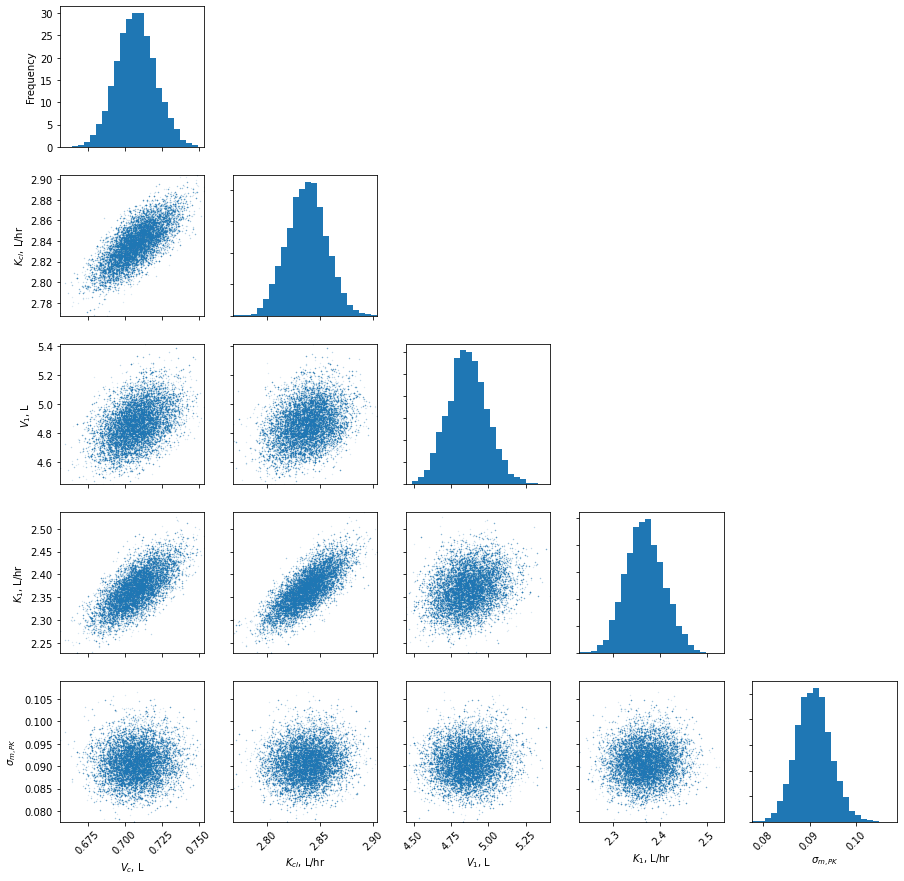

In [59]:
# pints.plot.trace(samples, parameter_names=PK_param_names)
# plt.show()
pints.plot.pairwise(np.vstack(samples[:,-int(0.89*num_samples):]), parameter_names=PK_param_names)
plt.show()

### PK: Experimental Data

In [60]:
df = pandas.read_csv("../Data_and_parameters/PK_real/data_refined_Docetaxel.csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
print(df)

unit = "ng/mL"
df = df.astype({'OBS': 'float64'})
df['OBS'] = df["OBS"]/1000  # Converting from ng/ml to mg/l

# Get actual dose amount
patient_info = pandas.read_csv("../Data_and_parameters/patient_details_refined_Docetaxel.csv")
patient_info = patient_info.loc[patient_info['ID'].isin(df.ID)].sort_values('ID', ignore_index=True)

dose_amount = patient_info.AMT.mean() # mg
dose_unit = "mg"
print("Average dose amount = " + str(dose_amount))

       ID  DOSE    TIME      OBS
0    5335   5.0   0.083  320.827
1    5335   5.0   1.167   19.586
2    5335   5.0   3.333   13.028
3    5335   5.0   4.250   12.074
4    5335   5.0   4.833   12.356
..    ...   ...     ...      ...
103  5370  15.0   0.416  462.413
104  5370  15.0   1.666  100.467
105  5370  15.0   3.333   45.856
106  5370  15.0   7.833   14.541
107  5370  15.0  10.000    6.640

[108 rows x 4 columns]
Average dose amount = 2.0


In [61]:
# Before starting the optimisation we should estimate the parameter Vol_C. We can do this by drawing a line 
# through the first 2 points and seeing where it crosses the y-axis
df['rank'] = df.sort_values('TIME').groupby('ID').cumcount()+1
first_points = df[df['rank'] == 1].sort_values('ID', ignore_index=True)
second_points = df[df['rank'] == 2].sort_values('ID', ignore_index=True)

y_0 = first_points['OBS'] - first_points['TIME'] * (
    (first_points['OBS'] - second_points['OBS'])
    / (first_points['TIME'] - second_points['TIME'])
)
Vol_C_approx = (patient_info['AMT']/y_0).mean()
print("Aproximate V_C:")
print(Vol_C_approx)

Aproximate V_C:
1.5259736140238604


In [63]:
PK_param_names = np.load("../Data_and_parameters/PK_sim/actual_params.npy")[0, :]

PK_model = Pints_PK_model(data=df, patient_info=patient_info, num_comp=2)
pseudo_times = PK_model.pseudotime
problem = pints.SingleOutputProblem(PK_model, pseudo_times, df['OBS'].to_numpy())
log_likelihood = MultiplicativeGaussianLogLikelihood(problem, fix_eta=1)
opt_params = np.load('../Data_and_parameters/PK_sim/opt_'+str(drug)+'.npy')

lower_bound = [0.1*Vol_C_approx, 0.01, 0.01*Vol_C_approx, 0.01, 0.0001]
upper_bound = [10*Vol_C_approx,   100,  100*Vol_C_approx,  100,      1]

log_prior = pints.UniformLogPrior(lower_bound, upper_bound)

num_iterations = len(opt_params)*5000  # 5000 iterations per parameter
num_samples = len(opt_params)*2500  # 2500 final samples per parameter

start_points = [np.exp((np.log(lower_bound)+np.log(opt_params))*0.5), opt_params, np.exp((np.log(upper_bound)+np.log(opt_params))*0.5)]
print(np.asarray(start_points))

[[3.19630576e-01 1.66832904e-01 2.74088618e-01 1.49509570e-01
  2.91537993e-03]
 [6.69498504e-01 2.78332178e+00 4.92305828e+00 2.23531116e+00
  8.49944016e-02]
 [3.19630576e+00 1.66832904e+01 2.74088618e+01 1.49509570e+01
  2.91537993e-01]]


In [9]:
samples = MCMC_run(log_likelihood, log_prior, start_points, num_iterations, num_samples)

In [64]:
# samples = np.asarray(samples)
# print(pints.MCMCSummary(samples[:,-int(0.9*num_samples):], parameter_names=PK_param_names))

# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PK_real/MCMC_samples_chain_'+str(chain), sample_chain)
samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PK_real/MCMC_samples_chain', n=3))

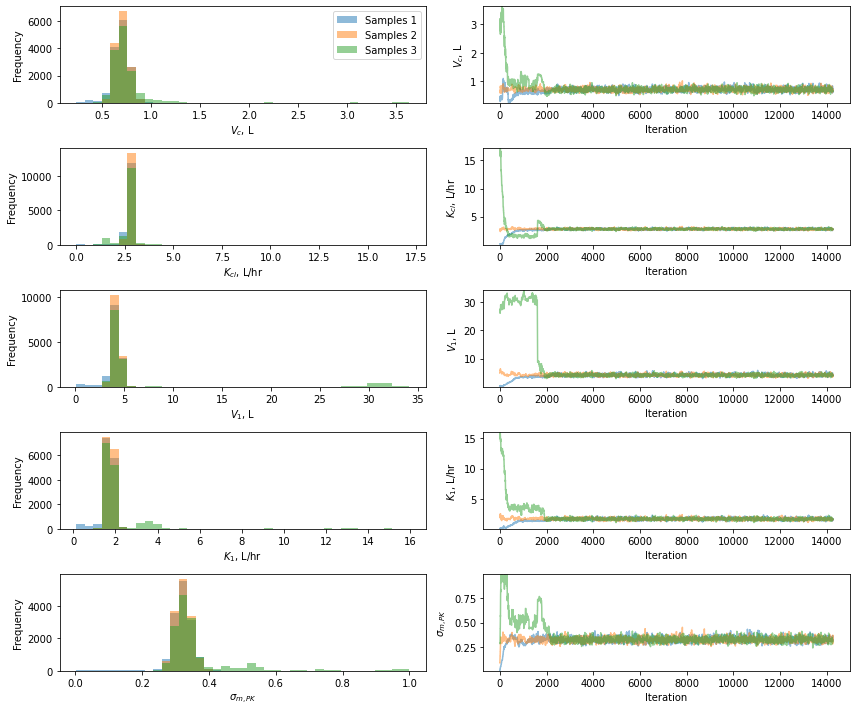

In [65]:
pints.plot.trace(samples, parameter_names=PK_param_names)
plt.show()
pints.plot.pairwise(np.vstack(samples[:,-int(0.9*num_samples):]), parameter_names=PK_param_names)
plt.show()

#### Bayesian Inference PD

**Simulated Data**

In [66]:
df = pandas.read_csv("../Data_and_parameters/PD_sim/sythesised_data_real_timepoints.csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
dose_amount = df.DOSE.mean()
dose_unit = "mg"
print(df)

print("Average dose amount = " + str(dose_amount))

        ID  DOSE   TIME          OBS
0      0.0   0.0  -48.0   996.613880
1      0.0   0.0   48.0  1093.703842
2      0.0   0.0  120.0   963.388943
3      0.0   0.0  192.0   708.445214
4      0.0   0.0  264.0   963.677974
..     ...   ...    ...          ...
475  314.0   3.0  192.0   746.021561
476  314.0   3.0  264.0  1295.751618
477  314.0   3.0  336.0  1852.455780
478  314.0   3.0  432.0   970.468193
479  314.0   3.0  552.0   954.674338

[480 rows x 4 columns]
Average dose amount = 1.5


In [67]:
PK_params = np.load("../Data_and_parameters/PK_sim/actual_params.npy")
PK_param_names = PK_params[0, :]
PK_params = PK_params[1, :].astype('float64')

PD_actual_params = np.load("../Data_and_parameters/PD_sim/actual_params.npy")
PD_param_names = PD_actual_params[0, :]
PD_actual_params = PD_actual_params[1, :].astype('float64')

print("Parameters used for simulated data:")
for i in range(0,len(PD_param_names)):
    print(PD_param_names[i] + " = " + str(PD_actual_params[i]))

PD_model = Pints_PD_model(PK_params[:-1], data=df, num_comp=2)
pseudo_times = PD_model.pseudotime
problem = pints.SingleOutputProblem(PD_model, pseudo_times, df['OBS'].to_numpy())

Parameters used for simulated data:
$R_0$ = 983.1
$MTT$ = 85.26
$\gamma$ = 0.44
$S$ = 20.0
$\sigma_{c, PD}$ = 42.43
$\eta$ = 1.0
$\sigma_{m, PD}$ = 0.13


In [68]:
df_before_0 = df[df["TIME"] < 0]
R_0_approx = np.mean(df_before_0["OBS"])
print("approximate R_0: ", R_0_approx)

approximate R_0:  964.886043416262


In [69]:
opt_df = pandas.read_csv("../Data_and_parameters/PD_sim/opt_results.csv")
opt_add = np.asarray(opt_df['Constant Noise'][0:5])
opt_mult = np.concatenate((
    np.asarray(opt_df['Relative Noise'][0:4]),
    np.asarray(opt_df['Relative Noise'][5:-1])
)) 
opt_mult_noeta = np.concatenate((
    np.asarray(opt_df['Relative Noise.1'][0:4]),
    np.asarray(opt_df['Relative Noise.1'][6:-1])
))
opt_comb = np.asarray(opt_df['Combined Noise'][0:-1])
opt_comb_noeta = np.concatenate((
    np.asarray(opt_df['Combined Noise.1'][0:5]),
    np.asarray(opt_df['Combined Noise.1'][6:-1])
))
opt_df

Parameter  Constant Noise  Relative Noise  Relative Noise.1  \
0         C_0      987.915343      988.257805        987.912849   
1         MTT       86.756146       85.629934         85.455867   
2       gamma        0.450199        0.440001          0.438664   
3       slope       19.324406       19.254358         18.953532   
4  sigma_base      166.636117             NaN               NaN   
5         eta             NaN        0.757568               NaN   
6   sigma_rel             NaN        0.900436          0.170891   
7  likelihood     2696.508936     3330.701798       3127.520807   

   Combined Noise  Combined Noise.1  Actual Parameters  
0      988.257806        988.265991             983.10  
1       85.629933         85.536864              85.26  
2        0.440001          0.438929               0.44  
3       19.254358         19.214238              20.00  
4        0.001000         33.937997              42.43  
5        0.757573               NaN               1.00  
6        0.900403          0.134538               0.13  
7     3126.533665       3126.787017                NaN

In [70]:
lower_bound = [0.1*R_0_approx, df['TIME'].max()*0.01, 0.005, 0.01,     0.001,      0.001, 0.001]
upper_bound = [10*R_0_approx,      df['TIME'].max(),     5,    100,   R_0_approx,   10,    0.99] # Problems at sigma_m=1?
num_iterations = len(lower_bound)*5000  # 10000 iterations per parameter
num_samples = len(lower_bound)*2500  # 2500 final samples per parameter

print(lower_bound)
print(upper_bound)


[96.48860434162621, 5.5200000000000005, 0.005, 0.01, 0.001, 0.001, 0.001]
[9648.86043416262, 552.0, 5, 100, 964.886043416262, 10, 0.99]


Constant

In [71]:
log_likelihood = GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(lower_bound[:5], upper_bound[:5])
start_points = [np.exp(np.log(lower_bound[:5])*0.25+np.log(opt_add)*0.75), opt_add, np.exp(np.log(upper_bound[:5])*0.25+np.log(opt_add)*0.75)]
print(start_points)

[array([5.52279349e+02, 4.35722470e+01, 1.46148955e-01, 2.91460441e+00,
       8.24758600e+00]), array([9.87915343e+02, 8.67561457e+01, 4.50198749e-01, 1.93244061e+01,
       1.66636117e+02]), array([1.74646065e+03, 1.37787543e+02, 8.21855970e-01, 2.91460441e+01,
       2.58491257e+02])]


In [18]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_sim/MCMC_add_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.14 seconds
20 	 0.45     	 0.15     	 0.4     	 nan     	 2.64 seconds
40 	 0.5     	 0.175     	 0.3     	 nan     	 5.23 seconds
60 	 0.5     	 0.1167     	 0.2333     	 nan     	 7.88 seconds
80 	 0.5125     	 0.1125     	 0.1875     	 nan     	 10.55 seconds
100 	 0.49     	 0.09     	 0.16     	 nan     	 13.21 seconds
120 	 0.4833     	 0.0917     	 0.1583     	 nan     	 15.84 seconds
140 	 0.5071     	 0.1     	 0.15     	 nan     	 18.5 seconds
160 	 0.4938     	 0.1     	 0.1437     	 nan     	 21.17 seconds
180 	 0.5     	 0.1111     	 0.1278     	 nan     	 23.82 seconds
200 	 0.5     	 0.11     	 0.14     	 nan     	 26.44 seconds
825 	 0.2436     	 0.1248     	 0.1394     	 nan     	 2 minutes, 0 seconds
...........................
End of Initial Phase
...........................


C:\Users\rebec\Documents\Myleotoxicity\Notebooks\Code\PD_model.py:41: RuntimeWarning: invalid value encountered in power
  feedback = np.power(


1450 	 0.2048     	 0.1448     	 0.1703     	 nan     	 3 minutes, 35 seconds
2075 	 0.2217     	 0.1533     	 0.1802     	 nan     	 5 minutes, 2 seconds
2700 	 0.2196     	 0.1652     	 0.1689     	 nan     	 6 minutes, 22 seconds
3325 	 0.2141     	 0.1753     	 0.1901     	 nan     	 7 minutes, 40 seconds
3950 	 0.219     	 0.1858     	 0.198     	 nan     	 8 minutes, 59 seconds
4575 	 0.2052     	 0.1886     	 0.2042     	 nan     	 10 minutes, 19 seconds
5200 	 0.2192     	 0.1965     	 0.2069     	 nan     	 11 minutes, 38 seconds
5825 	 0.2271     	 0.1973     	 0.2113     	 nan     	 12 minutes, 58 seconds
6450 	 0.2301     	 0.1994     	 0.213     	 nan     	 14 minutes, 18 seconds
7075 	 0.2311     	 0.2013     	 0.2144     	 nan     	 15 minutes, 37 seconds
7700 	 0.2296     	 0.2056     	 0.217     	 nan     	 16 minutes, 57 seconds
8325 	 0.232     	 0.2074     	 0.2179     	 nan     	 18 minutes, 17 seconds
8950 	 0.2313     	 0.2082     	 0.22     	 nan     	 19 minute

In [72]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_sim/MCMC_add_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_add_samples_chain', n=3))

In [73]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(samples[:,-num_samples:], parameter_names=PD_param_names[:5]).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)

df_summary = df_summary.round(decimals=4)
df_summary = pandas.DataFrame(np.insert(df_summary.values, 5, values=[PD_param_names[6]] + ['.']*9, axis=0), columns = df_summary.columns)
df_summary['actual value'] = np.concatenate((PD_actual_params[:5],PD_actual_params[6:]))

In [74]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile', 
    'actual value'
])

fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "sim_MCMC_add_table.svg")

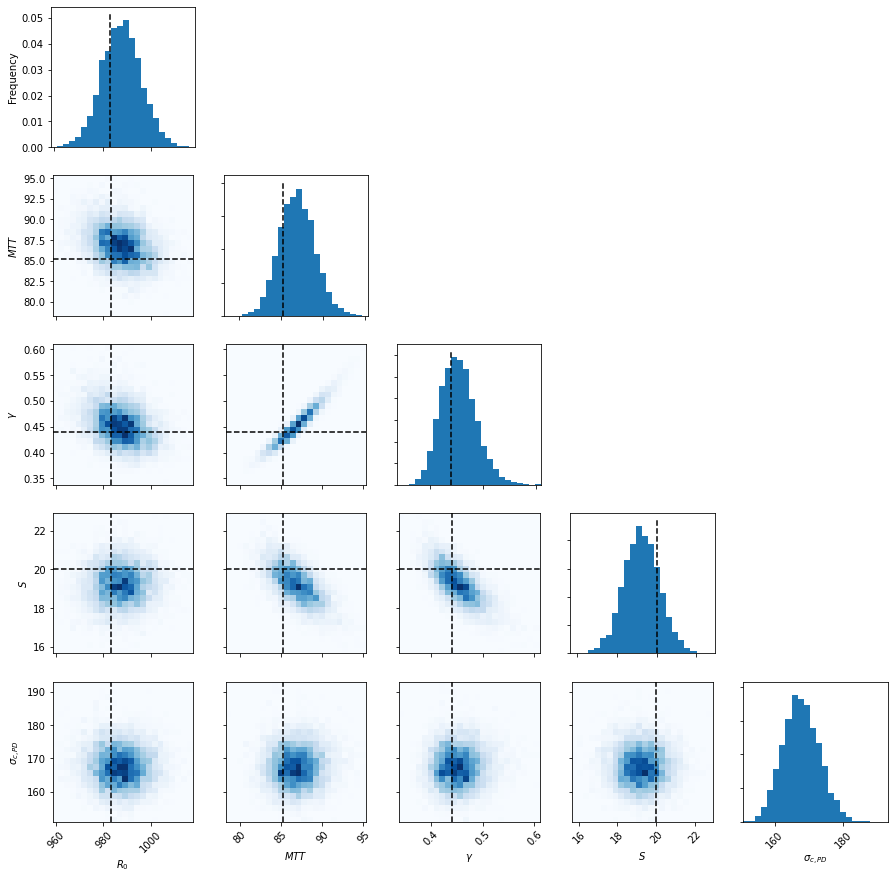

In [75]:
pints.plot.trace(samples, parameter_names=PD_param_names[:5])
# plt.savefig(image_file + "sim_MCMC_add_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(samples[:,-int(0.7*num_samples):]), 
    heatmap=True,
    ref_parameters=PD_actual_params[:5],
    parameter_names=PD_param_names[:5],
)
# plt.savefig(image_file + "sim_MCMC_add_pairs.svg")
plt.show()

In [76]:
chain_1_mean = np.mean(samples[0,-num_samples:], axis=0)
chain_2_mean = np.mean(samples[1,-num_samples:], axis=0)

pints.plot.function_between_points(log_likelihood, chain_1_mean, (50*chain_1_mean+50*chain_2_mean)/100, padding=0, evaluations=200)
plt.show()

**Relative with no eta**

In [77]:
log_likelihood =  MultiplicativeGaussianLogLikelihood(problem, fix_eta=1.0)
mult_lb = np.asarray(lower_bound[:4]+lower_bound[6:])
mult_ub = np.asarray(upper_bound[:4]+upper_bound[6:])
log_prior = pints.UniformLogPrior(mult_lb, mult_ub)

# start_points = [
#     np.exp(np.log(mult_lb)*0.2+np.log(opt_mult_noeta)*0.8), 
#     opt_mult_noeta, 
#     np.exp(np.log(mult_ub)*0.2+np.log(opt_mult_noeta)*0.8)
# ]
# opt_mult_noeta = opt_mult_noeta.astype(float)
point_1 = 0.5*opt_mult_noeta
if any(point_1 <= mult_lb):
    for point_index in range(len(point_1)):
        point_1[point_index] = max(point_1[point_index], opt_mult_noeta[point_index]*0.5+0.5*mult_lb[point_index])
point_3 = 1.5*opt_mult_noeta
if any(point_3 >= mult_ub):
    for point_index in range(len(point_3)):
        point_3[point_index] = min(point_3[point_index], opt_mult_noeta[point_index]*0.5+0.5*mult_ub[point_index])
start_points = [point_1, opt_mult_noeta, point_3]
print(np.asarray(start_points))

[[4.93956425e+02 4.27279337e+01 2.19332220e-01 9.47676610e+00
  8.54455674e-02]
 [9.87912849e+02 8.54558674e+01 4.38664441e-01 1.89535322e+01
  1.70891135e-01]
 [1.48186927e+03 1.28183801e+02 6.57996661e-01 2.84302983e+01
  2.56336702e-01]]


In [14]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_sim/MCMC_mult_noeta_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.14 seconds
20 	 0.6     	 0.0     	 0.45     	 nan     	 2.89 seconds
40 	 0.5     	 0.0     	 0.375     	 nan     	 5.79 seconds
60 	 0.4333     	 0.0     	 0.3167     	 nan     	 8.86 seconds
80 	 0.4     	 0.0     	 0.2875     	 nan     	 11.99 seconds
100 	 0.33     	 0.0     	 0.28     	 nan     	 15.15 seconds
120 	 0.275     	 0.0     	 0.2833     	 nan     	 18.36 seconds
140 	 0.2357     	 0.0     	 0.2643     	 nan     	 21.53 seconds
160 	 0.2062     	 0.0     	 0.2875     	 nan     	 24.73 seconds
180 	 0.2056     	 0.0     	 0.2778     	 nan     	 27.87 seconds
200 	 0.19     	 0.0     	 0.26     	 nan     	 30.98 seconds
1075 	 0.1786     	 0.0177     	 0.1191     	 nan     	 2 minutes, 41 seconds
...........................
End of Initial Phase
...........................
1950 	 0.2046     	 0.0528     	 0.1118     	 nan     	 4 minutes, 40 seconds
2825 	 0.2004     	 0.0949 

In [78]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_sim/MCMC_mult_noeta_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_mult_noeta_samples_chain', n=3))

In [79]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(samples[:,-num_samples:], parameter_names=np.concatenate((PD_param_names[:4],PD_param_names[6:]))).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)
df_summary = df_summary.round(decimals=4)
df_summary = pandas.DataFrame(np.insert(
    df_summary.values, 
    4, 
    values=[PD_param_names[5]] + ['.']*9, 
    axis=0
), columns = df_summary.columns)
df_summary = pandas.DataFrame(np.insert(
    df_summary.values, 
    4, 
    values=[PD_param_names[4]] + ['.']*9, 
    axis=0
), columns = df_summary.columns)
df_summary['actual value'] = PD_actual_params # np.concatenate((PD_actual_params[:5],PD_actual_params[6:]))

In [80]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile', 
    'actual value'
])

fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "sim_MCMC_mult_noeta_table.svg")

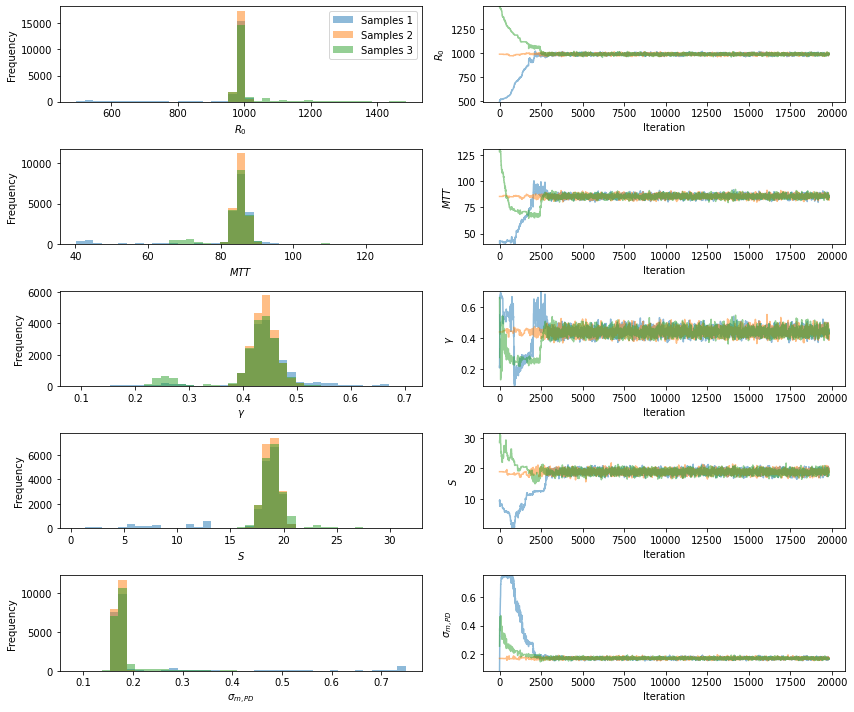

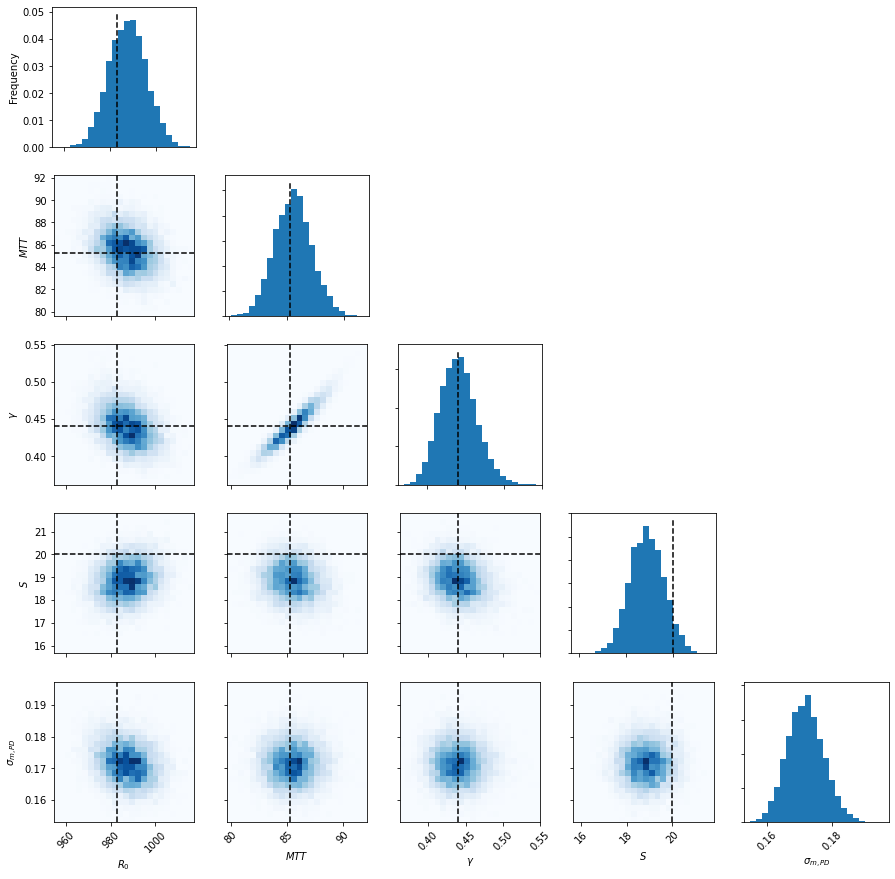

In [81]:
pints.plot.trace(np.asarray(samples), parameter_names=np.concatenate((PD_param_names[:4], PD_param_names[6:])))
# plt.savefig(image_file + "sim_MCMC_mult_noeta_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(np.asarray(samples)[:,-int(0.9*num_samples):]), 
    heatmap=True,
    ref_parameters=np.concatenate((PD_actual_params[:4], PD_actual_params[6:])),
    parameter_names=np.concatenate((PD_param_names[:4], PD_param_names[6:])),
)
# plt.savefig(image_file + "sim_MCMC_mult_noeta_pairs.svg")
plt.show()

Relative Noise with Eta

In [82]:
log_likelihood =  MultiplicativeGaussianLogLikelihood(problem)
mult_lb = np.asarray(lower_bound[:4]+lower_bound[5:])
mult_ub = np.asarray(upper_bound[:4]+upper_bound[5:])
# log_prior = pints.UniformLogPrior(mult_lb, mult_ub)

# start_points = [
#     np.exp(np.log(mult_lb)*0.25+np.log(opt_mult)*0.75), 
#     opt_mult, 
#     np.exp(np.log(mult_ub)*0.25+np.log(opt_mult)*0.75)
# ]

point_1 = 0.5*opt_mult
if any(point_1 <= mult_lb):
    for point_index in range(len(point_1)):
        point_1[point_index] = max(point_1[point_index], opt_mult[point_index]*0.5+0.5*mult_lb[point_index])
point_3 = 1.5*opt_mult
if any(point_3 >= mult_ub):
    for point_index in range(len(point_3)):
        point_3[point_index] = min(point_3[point_index], opt_mult[point_index]*0.5+0.5*mult_ub[point_index])
start_points = [point_1, opt_mult, point_3]
print(np.asarray(start_points))

[[4.94128903e+02 4.28149668e+01 2.20000508e-01 9.62717898e+00
  3.78784165e-01 4.50217869e-01]
 [9.88257805e+02 8.56299336e+01 4.40001016e-01 1.92543580e+01
  7.57568330e-01 9.00435737e-01]
 [1.48238671e+03 1.28444900e+02 6.60001524e-01 2.88815369e+01
  1.13635250e+00 9.45217869e-01]]


In [13]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_sim/MCMC_mult_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.14 seconds
20 	 0.45     	 0.0     	 0.25     	 nan     	 2.86 seconds
40 	 0.475     	 0.0     	 0.125     	 nan     	 5.65 seconds
60 	 0.3333     	 0.0167     	 0.0833     	 nan     	 8.52 seconds
80 	 0.275     	 0.0125     	 0.075     	 nan     	 11.34 seconds
100 	 0.23     	 0.01     	 0.06     	 nan     	 14.1 seconds
120 	 0.1917     	 0.0083     	 0.0667     	 nan     	 16.85 seconds
140 	 0.1714     	 0.0071     	 0.0643     	 nan     	 19.6 seconds
160 	 0.1562     	 0.0063     	 0.0625     	 nan     	 22.34 seconds
180 	 0.1389     	 0.0111     	 0.0667     	 nan     	 25.04 seconds
200 	 0.125     	 0.01     	 0.06     	 nan     	 27.72 seconds
1075 	 0.0642     	 0.0037     	 0.0419     	 nan     	 2 minutes, 24 seconds
...........................
End of Initial Phase
...........................
1950 	 0.0892     	 0.039     	 0.0569     	 nan     	 4 minutes, 15 seconds
2825

In [83]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_sim/MCMC_mult_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_mult_samples_chain', n=3))

In [84]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(
        samples[:,-num_samples:], 
        parameter_names=np.concatenate((PD_param_names[:4],PD_param_names[5:]))
    ).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)
df_summary = df_summary.round(decimals=4)
# df_summary = pandas.DataFrame(np.insert(
#     df_summary.values, 
#     4, 
#     values=[PD_param_names[5]] + ['.']*9, 
#     axis=0
# ), columns = df_summary.columns)
df_summary = pandas.DataFrame(np.insert(
    df_summary.values, 
    4, 
    values=[PD_param_names[4]] + ['.']*9, 
    axis=0
), columns = df_summary.columns)
df_summary['actual value'] = PD_actual_params # np.concatenate((PD_actual_params[:5],PD_actual_params[6:]))

In [85]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile', 
    'actual value'
])

fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "sim_MCMC_mult_table.svg")

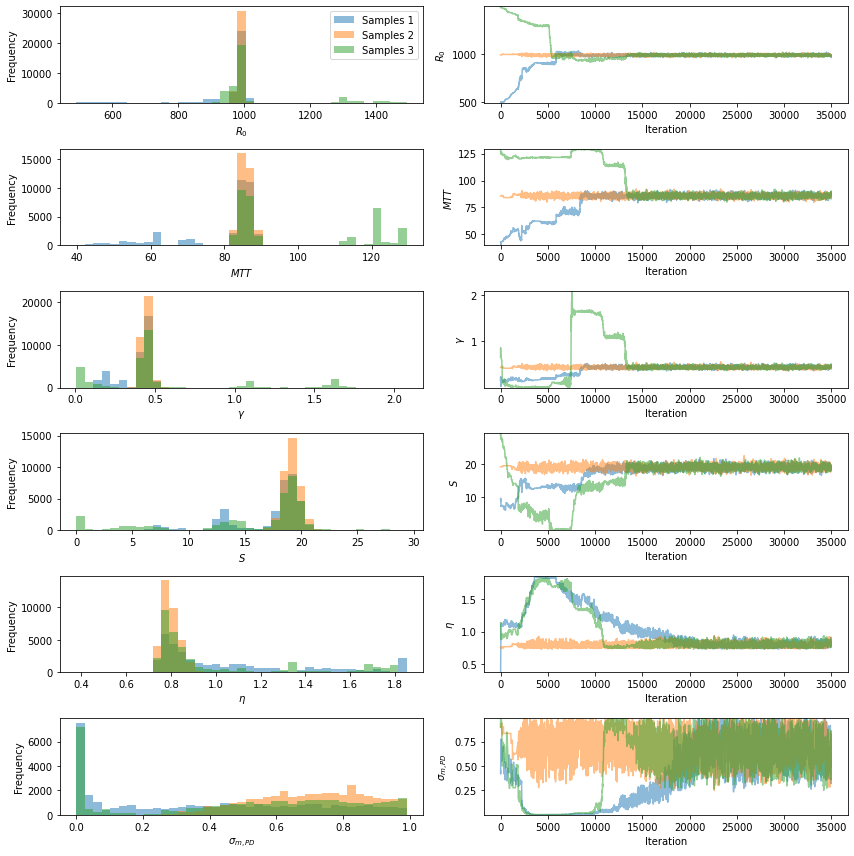

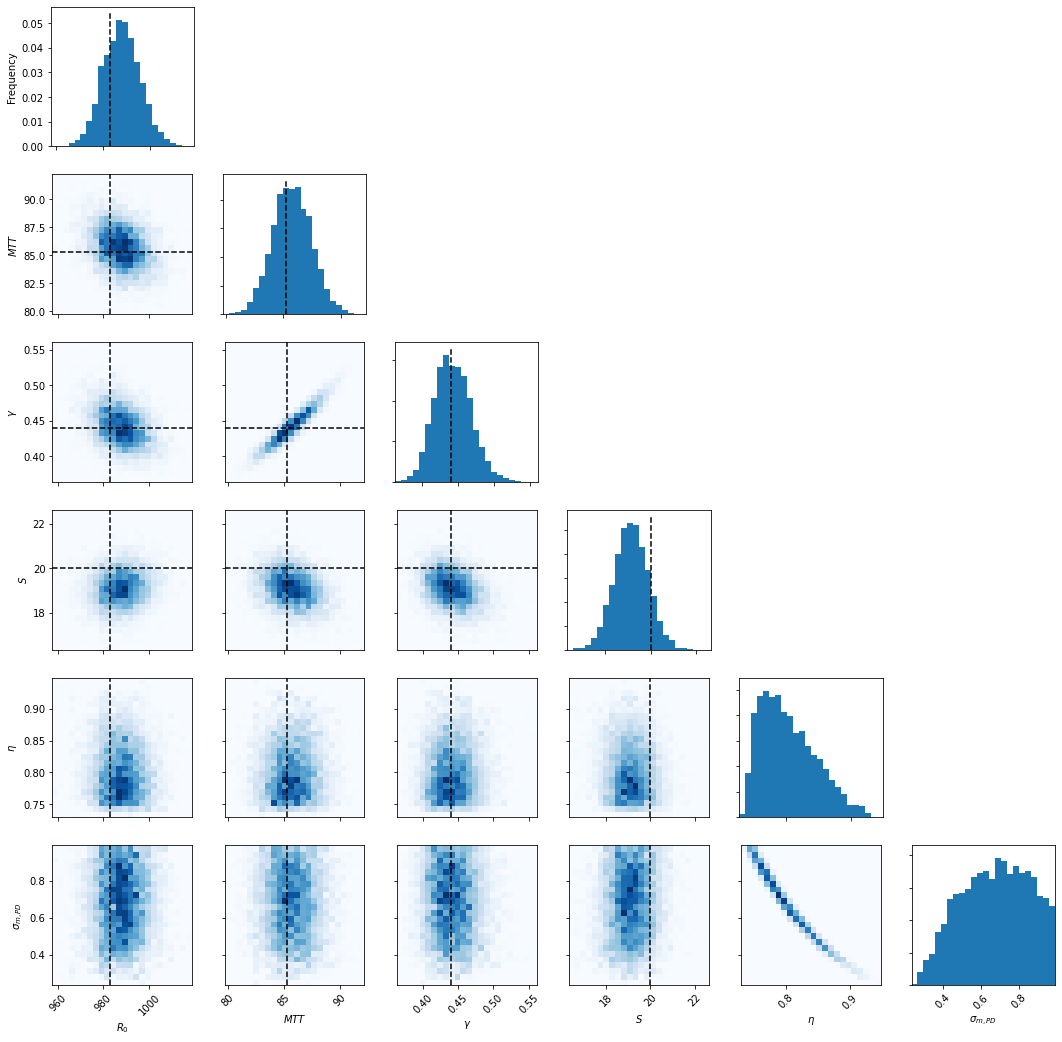

In [86]:
pints.plot.trace(np.asarray(samples), parameter_names=np.concatenate((PD_param_names[:4], PD_param_names[5:])))
# plt.savefig(image_file + "sim_MCMC_mult_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(np.asarray(samples)[:,-int(0.9*num_samples):]), 
    heatmap=True,
    ref_parameters=np.concatenate((PD_actual_params[:4], PD_actual_params[5:])),
    parameter_names=np.concatenate((PD_param_names[:4], PD_param_names[5:])),
)
# plt.savefig(image_file + "sim_MCMC_mult_pairs.svg")
plt.show()

Combined Noise with fixed eta

In [87]:
log_likelihood =  ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=[None, 1, None])
comb_lb = np.asarray(lower_bound[:5]+lower_bound[6:])
comb_ub = np.asarray(upper_bound[:5]+upper_bound[6:])
log_prior = pints.UniformLogPrior(comb_lb, comb_ub)

start_points = [
    np.exp(np.log(comb_lb)*0.25+0.75*np.log(opt_comb_noeta)), 
    opt_comb_noeta, 
    np.exp(np.log(comb_ub)*0.25+0.75*np.log(opt_comb_noeta))]

In [36]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_sim/MCMC_comb_noeta_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.14 seconds
20 	 0.55     	 0.0     	 0.35     	 nan     	 2.73 seconds
40 	 0.475     	 0.0     	 0.475     	 nan     	 5.47 seconds
60 	 0.4833     	 0.0     	 0.35     	 nan     	 8.19 seconds
80 	 0.4875     	 0.0     	 0.3     	 nan     	 10.88 seconds
100 	 0.51     	 0.01     	 0.26     	 nan     	 13.56 seconds
120 	 0.475     	 0.0083     	 0.2417     	 nan     	 16.27 seconds
140 	 0.4571     	 0.0143     	 0.2286     	 nan     	 18.91 seconds
160 	 0.45     	 0.0125     	 0.2125     	 nan     	 21.6 seconds
180 	 0.45     	 0.0111     	 0.1889     	 nan     	 24.33 seconds
200 	 0.445     	 0.01     	 0.17     	 nan     	 27.09 seconds
1075 	 0.3209     	 0.0177     	 0.0679     	 nan     	 2 minutes, 16 seconds
...........................
End of Initial Phase
...........................
1950 	 0.2708     	 0.0518     	 0.0836     	 nan     	 3 minutes, 59 seconds


C:\Users\rebec\Documents\Myleotoxicity\Notebooks\Code\Likelihoods.py:268: RuntimeWarning:

overflow encountered in square

C:\Users\rebec\Documents\Myleotoxicity\Notebooks\Code\Likelihoods.py:268: RuntimeWarning:

invalid value encountered in divide

C:\Users\rebec\Documents\Myleotoxicity\Notebooks\Code\PD_model.py:41: RuntimeWarning:

invalid value encountered in power

C:\Users\rebec\Documents\Myleotoxicity\Notebooks\Code\Likelihoods.py:267: RuntimeWarning:

invalid value encountered in log



2825 	 0.2432     	 0.0903     	 0.1115     	 nan     	 6 minutes, 1 second
3700 	 0.2416     	 0.1162     	 0.1514     	 nan     	 7 minutes, 56 seconds
4575 	 0.2345     	 0.1399     	 0.165     	 nan     	 9 minutes, 50 seconds
5450 	 0.2284     	 0.1519     	 0.1697     	 nan     	 11 minutes, 45 seconds
6325 	 0.2274     	 0.1651     	 0.181     	 nan     	 13 minutes, 40 seconds
7200 	 0.2283     	 0.1728     	 0.1885     	 nan     	 15 minutes, 35 seconds
8075 	 0.2296     	 0.1781     	 0.1907     	 nan     	 17 minutes, 30 seconds
8950 	 0.2275     	 0.1827     	 0.1956     	 nan     	 19 minutes, 23 seconds
9825 	 0.2295     	 0.1876     	 0.1994     	 nan     	 21 minutes, 15 seconds
10700 	 0.2288     	 0.189     	 0.2004     	 nan     	 23 minutes, 8 seconds
11575 	 0.2297     	 0.1921     	 0.2032     	 nan     	 25 minutes, 1 second
12450 	 0.231     	 0.1943     	 0.2063     	 nan     	 26 minutes, 54 seconds
13325 	 0.2316     	 0.1977     	 0.2086     	 nan     	 28 m

In [88]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_sim/MCMC_comb_noeta_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_comb_noeta_samples_chain', n=3))

In [89]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(
        samples[:,-num_samples:], 
        parameter_names=np.concatenate((PD_param_names[:5],PD_param_names[6:]))
    ).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)
df_summary = df_summary.round(decimals=4)
df_summary = pandas.DataFrame(np.insert(
    df_summary.values, 
    5, 
    values=[PD_param_names[5]] + ['.']*9, 
    axis=0
), columns = df_summary.columns)
df_summary['actual value'] = PD_actual_params

In [90]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile', 
    'actual value'
])

fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "sim_MCMC_comb_noeta_table.svg")

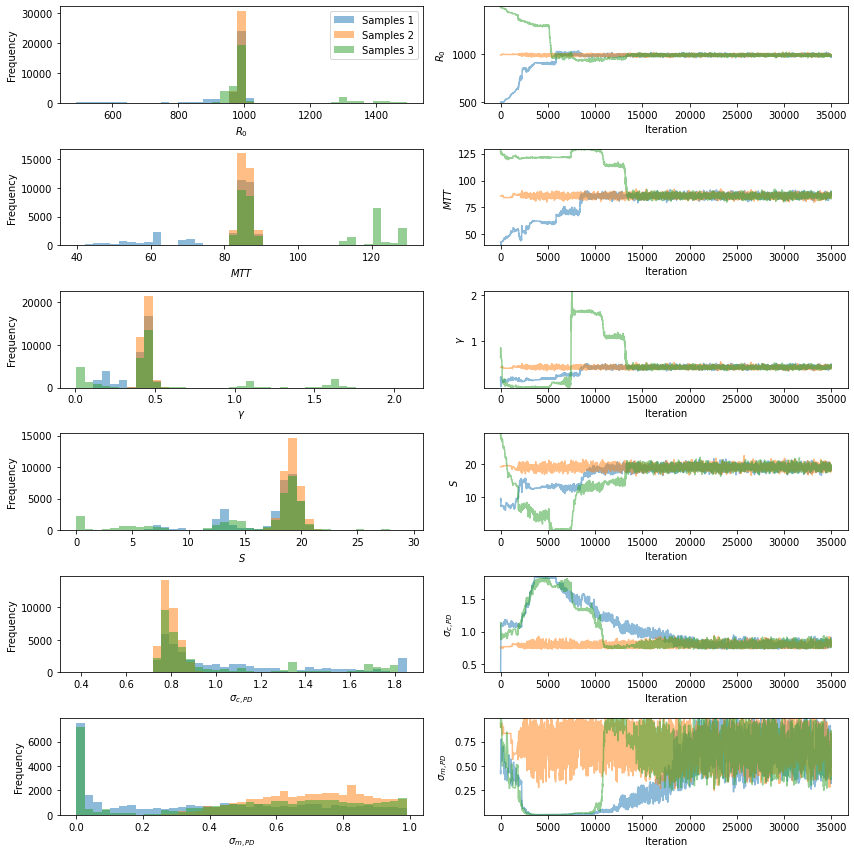

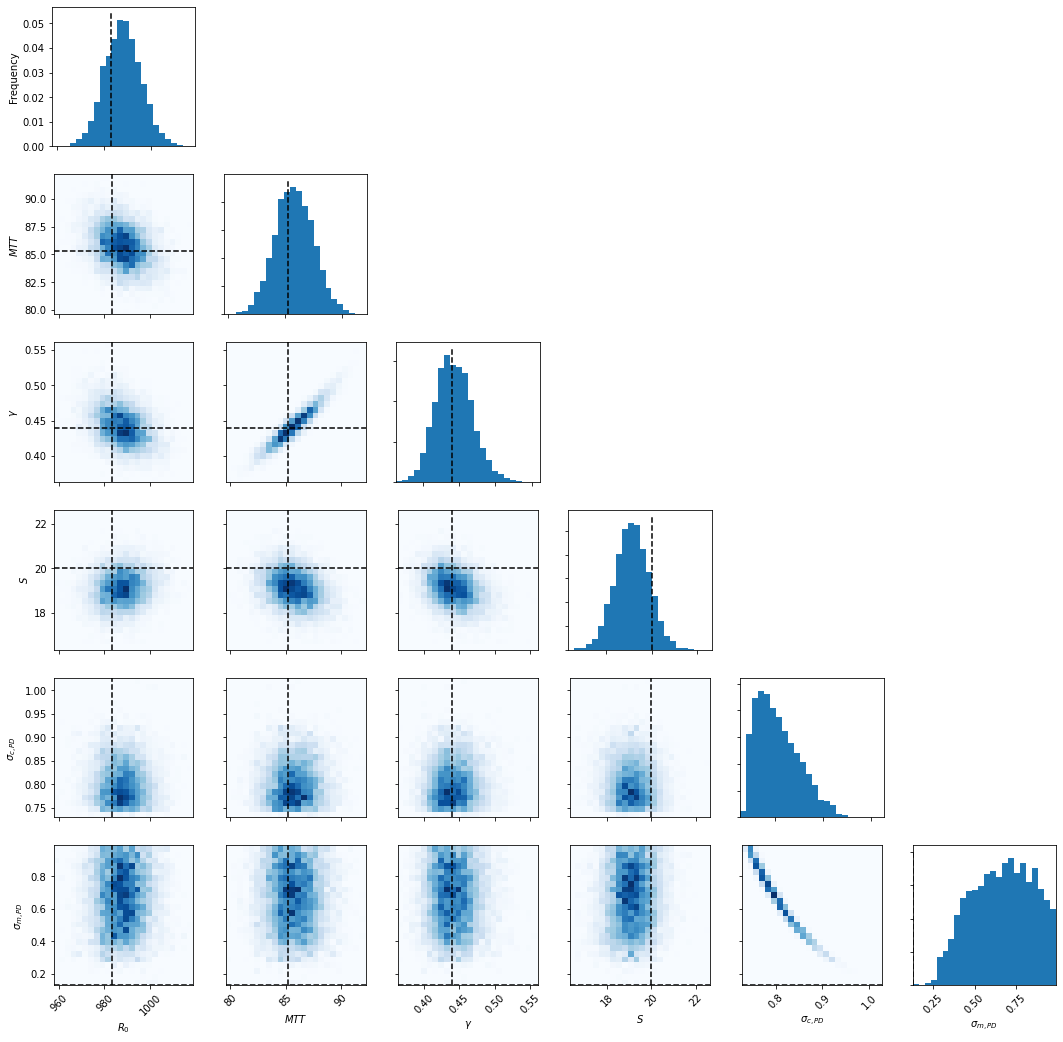

In [91]:
pints.plot.trace(samples, parameter_names=np.concatenate((PD_param_names[:5],PD_param_names[6:])))
# plt.savefig(image_file + "sim_MCMC_comb_noeta_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(samples[:,-num_samples:]), 
    heatmap=True,
    ref_parameters=np.concatenate((PD_actual_params[:5],PD_actual_params[6:])),
    parameter_names=np.concatenate((PD_param_names[:5],PD_param_names[6:])),
)
# plt.savefig(image_file + "sim_MCMC_comb_noeta_pairs.svg")
plt.show()

Combined Noise with eta

In [92]:
log_likelihood =  ConstantAndMultiplicativeGaussianLogLikelihood(problem)
# comb_lb = np.asarray(lower_bound[:4]+lower_bound[5:])
# comb_ub = np.asarray(upper_bound[:4]+upper_bound[5:])
log_prior = pints.UniformLogPrior(lower_bound, upper_bound)

start_points = [
    np.exp(np.log(lower_bound)*0.25+0.75*np.log(opt_comb)), 
    opt_comb, 
    np.exp(np.log(upper_bound)*0.25+0.75*np.log(opt_comb))]
print(start_points)


[array([5.52422929e+02, 4.31473345e+01, 1.43658971e-01, 2.90667705e+00,
       1.00000000e-03, 1.44400353e-01, 1.64371937e-01]), array([9.88257806e+02, 8.56299326e+01, 4.40001005e-01, 1.92543580e+01,
       1.00000001e-03, 7.57572738e-01, 9.00402927e-01]), array([1.74691469e+03, 1.36443852e+02, 8.07853764e-01, 2.90667705e+01,
       3.13414444e-02, 1.44400353e+00, 9.22011785e-01])]


In [93]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_sim/MCMC_comb_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.26 seconds
20 	 0.35     	 0.0     	 0.15     	 nan     	 4.69 seconds
Error for parameters: [5.69964801e+02 4.48117310e+01 1.22941592e-01 2.43163535e+00
 4.70866421e-03 6.28428265e-01 4.83385132e-01]


KeyboardInterrupt: 

In [94]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_sim/MCMC_comb_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_comb_samples_chain', n=3))

In [95]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(samples[:,-num_samples:], parameter_names=PD_param_names).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)

df_summary = df_summary.round(decimals=4)
df_summary['actual value'] = PD_actual_params # np.concatenate((PD_actual_params[:5],PD_actual_params[6:]))

In [96]:
parameter_names = ["$R_0$", "$MTT$", "$\gamma$", "$S$", "$\sigma_{c, PD}$", "$\eta$", "$\sigma_{m, PD}$"]
df_summary['parameter'] = parameter_names
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile', 
    'actual value'
])
fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "sim_MCMC_comb_table.svg")

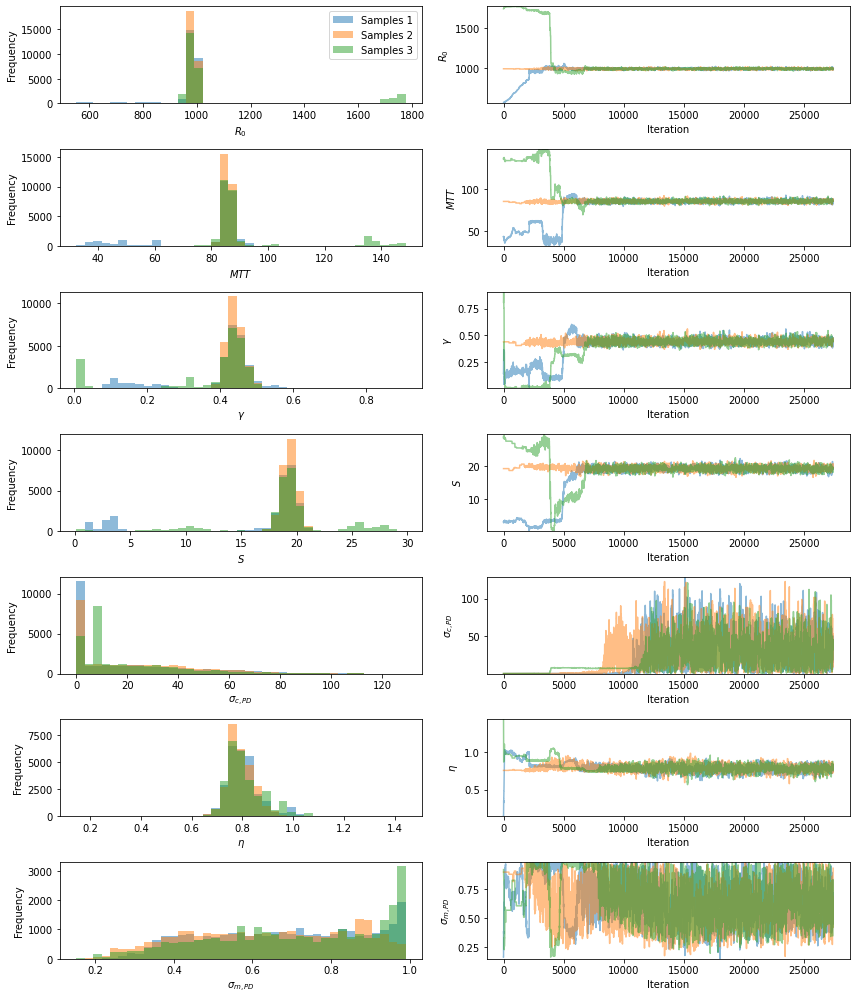

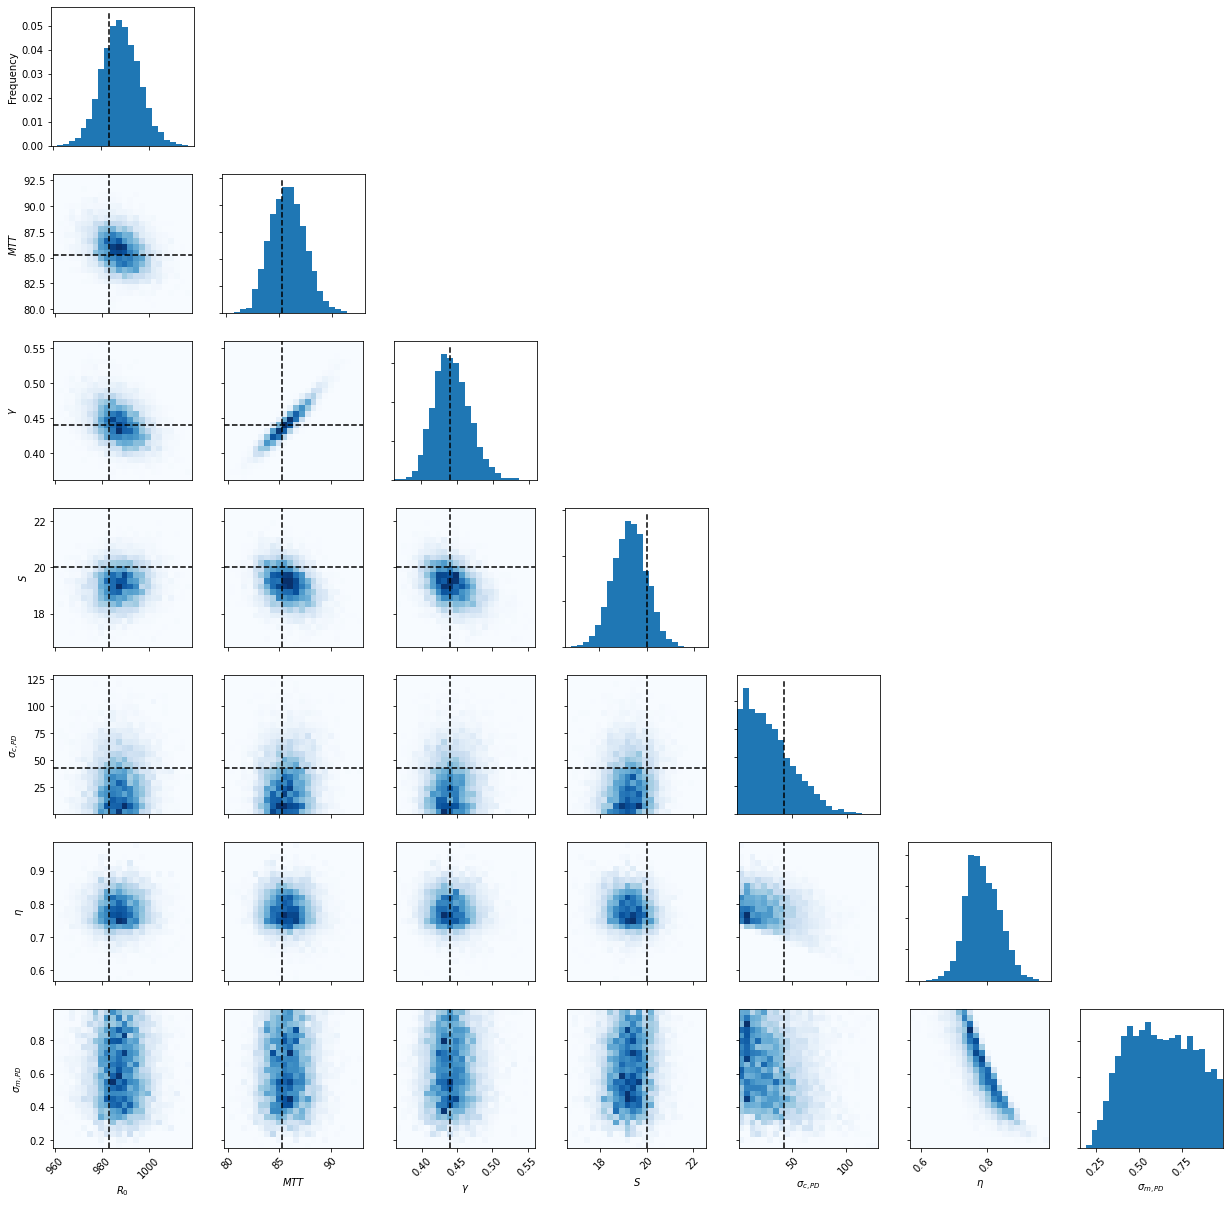

In [97]:
from pylab import rcParams
# rcParams['figure.figsize'] = 500/300, 360/300
pints.plot.trace(samples, parameter_names=parameter_names)
# plt.savefig(image_file + "sim_MCMC_comb_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(samples[:,-num_samples:]), 
    heatmap=True,
    ref_parameters=PD_actual_params,
    parameter_names=parameter_names,
)
# plt.savefig(image_file + "sim_MCMC_comb_pairs.svg")
plt.show()

### PD - Experimental Data

In [98]:
df = pandas.read_csv("../Data_and_parameters/PD_real/data_refined_"+drug+"_"+observation_name+".csv")
df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
print(df)

unit = "10^3/mcL"
df = df.astype({'OBS': 'float64'})

# Get actual dose amount
patient_info = pandas.read_csv("../Data_and_parameters/patient_details_refined_Docetaxel.csv")
patient_info = patient_info.loc[patient_info['ID'].isin(df.ID)].sort_values('ID', ignore_index=True)
# print(patient_info)
dose_amount = patient_info.AMT.mean() # mg
dose_unit = "mg"
print("Average dose amount = " + str(dose_amount))

       ID  DOSE   TIME     OBS
0    5061   0.0  -48.0   937.0
1    5061   0.0   24.0   833.0
2    5061   0.0   96.0  1156.0
3    5061   0.0  168.0  1068.0
4    5061   0.0  240.0  1136.0
..    ...   ...    ...     ...
350  5144  10.0  216.0   909.0
351  5144  10.0  288.0   721.0
352  5144  10.0  360.0  1277.0
353  5144  10.0  480.0   912.0
354  5144  10.0  552.0  1398.0

[355 rows x 4 columns]
Average dose amount = 1.519125


In [99]:
PK_params = np.load('../Data_and_parameters/PK_real/opt_'+str(drug)+'.npy')
PK_param_names = np.load("../Data_and_parameters/PK_sim/actual_params.npy")[0, :]
PD_param_names = np.load("../Data_and_parameters/PD_sim/actual_params.npy")[0, :]

PD_model = Pints_PD_model(PK_params[:-1], data=df, patient_info=patient_info, num_comp=2)
pseudo_times = PD_model.pseudotime
problem = pints.SingleOutputProblem(PD_model, pseudo_times, df['OBS'].to_numpy())

In [100]:
df_before_0 = df[df["TIME"] < 0]
R_0_approx = np.mean(df_before_0["OBS"])
print("approximate R_0: ", R_0_approx)

approximate R_0:  939.2


In [101]:
opt_df = pandas.read_csv("../Data_and_parameters/PD_real/"+drug+"_opt_results.csv")
opt_add = np.asarray(opt_df['Constant Noise'][0:5])
opt_mult = np.concatenate((
    np.asarray(opt_df['Relative Noise'][0:4]),
    np.asarray(opt_df['Relative Noise'][5:-1])
)) 
opt_mult_noeta = np.concatenate((
    np.asarray(opt_df['Relative Noise.1'][0:4]),
    np.asarray(opt_df['Relative Noise.1'][6:-1])
))
opt_comb = np.asarray(opt_df['Combined Noise'][0:-1])
opt_comb_noeta = np.concatenate((
    np.asarray(opt_df['Combined Noise.1'][0:5]),
    np.asarray(opt_df['Combined Noise.1'][6:-1])
))
opt_df

Parameter  Constant Noise  Relative Noise  Relative Noise.1  \
0             $R_0$      989.964402      989.695706        987.545964   
1             $MTT$       87.650176       89.494486         90.630897   
2          $\gamma$        0.472429        0.498154          0.515511   
3               $S$       15.025145       12.845063         12.056248   
4  $\sigma_{c, PD}$      193.766352             NaN               NaN   
5            $\eta$             NaN        0.770514               NaN   
6  $\sigma_{m, PD}$             NaN        0.990000          0.207393   
7        Likelihood    -2048.080777    -2381.327693      -2385.029195   

   Combined Noise  Combined Noise.1  
0      989.578934        990.318753  
1       88.120771         87.113505  
2        0.480601          0.465566  
3       14.774223         15.052243  
4      193.083088        192.803545  
5        0.814641               NaN  
6        0.001063          0.001000  
7    -2373.392093      -2373.402029

In [102]:
lower_bound = [0.1*R_0_approx, df['TIME'].max()*0.01, 0.005, 0.01,     0.001,      0.001, 0.001]
upper_bound = [10*R_0_approx,      df['TIME'].max(),     5,    100,   R_0_approx,   10,    0.99] # Problems at sigma_m=1?
num_iterations = len(lower_bound)*5000  # 5000 iterations per parameter
num_samples = len(lower_bound)*2500  # 2500 final samples per parameter

print(lower_bound)
print(upper_bound)


[93.92000000000002, 5.5200000000000005, 0.005, 0.01, 0.001, 0.001, 0.001]
[9392.0, 552.0, 5, 100, 939.2, 10, 0.99]


Constant

In [103]:
log_likelihood = GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(lower_bound[:5], upper_bound[:5])
start_points = [
    np.exp(np.log(lower_bound[:5])*0.2+np.log(opt_add)*0.8), 
    opt_add, 
    np.exp(np.log(upper_bound[:5])*0.2+np.log(opt_add)*0.8)
]
print(np.asarray(start_points))

[[6.18083684e+02 5.04185147e+01 1.90223076e-01 3.47900401e+00
  1.69755045e+01]
 [9.89964402e+02 8.76501756e+01 4.72428947e-01 1.50251446e+01
  1.93766352e+02]
 [1.55255602e+03 1.26645583e+02 7.57291708e-01 2.19510313e+01
  2.65689449e+02]]


In [14]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_real/MCMC_add_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.12 seconds
20 	 0.4     	 0.2     	 0.55     	 nan     	 2.12 seconds
40 	 0.45     	 0.15     	 0.325     	 nan     	 4.18 seconds
60 	 0.45     	 0.2167     	 0.2333     	 nan     	 6.22 seconds
80 	 0.475     	 0.175     	 0.2125     	 nan     	 8.33 seconds
100 	 0.45     	 0.16     	 0.19     	 nan     	 10.37 seconds
120 	 0.4667     	 0.175     	 0.1833     	 nan     	 12.44 seconds
140 	 0.4571     	 0.1643     	 0.1857     	 nan     	 14.54 seconds
160 	 0.45     	 0.175     	 0.1625     	 nan     	 16.73 seconds
180 	 0.4333     	 0.1667     	 0.1556     	 nan     	 18.88 seconds
200 	 0.415     	 0.185     	 0.155     	 nan     	 20.96 seconds
1075 	 0.3721     	 0.2307     	 0.2028     	 nan     	 1 minute, 48 seconds
...........................
End of Initial Phase
...........................
1950 	 0.3349     	 0.2426     	 0.2344     	 nan     	 3 minutes, 18 seconds
2825 	 0

In [104]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_real/MCMC_add_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_real/MCMC_add_samples_chain', n=3))

In [105]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(samples[:,-int(0.9*num_samples):], parameter_names=PD_param_names[:5]).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)

df_summary = df_summary.round(decimals=4)
df_summary = pandas.DataFrame(np.insert(df_summary.values, 5, values=[PD_param_names[6]] + ['.']*9, axis=0), columns = df_summary.columns)

In [106]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile'
])
df_summary_reduced['parameter'] =[
    "R_0$", 
    "MTT$", 
    "\gamma$", 
    "S$", 
    "\sigma_{c, \\textrm{PD}}$",
    "\sigma_{m, \\textrm{PD}}$"
]
fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "real_MCMC_add_table.svg")

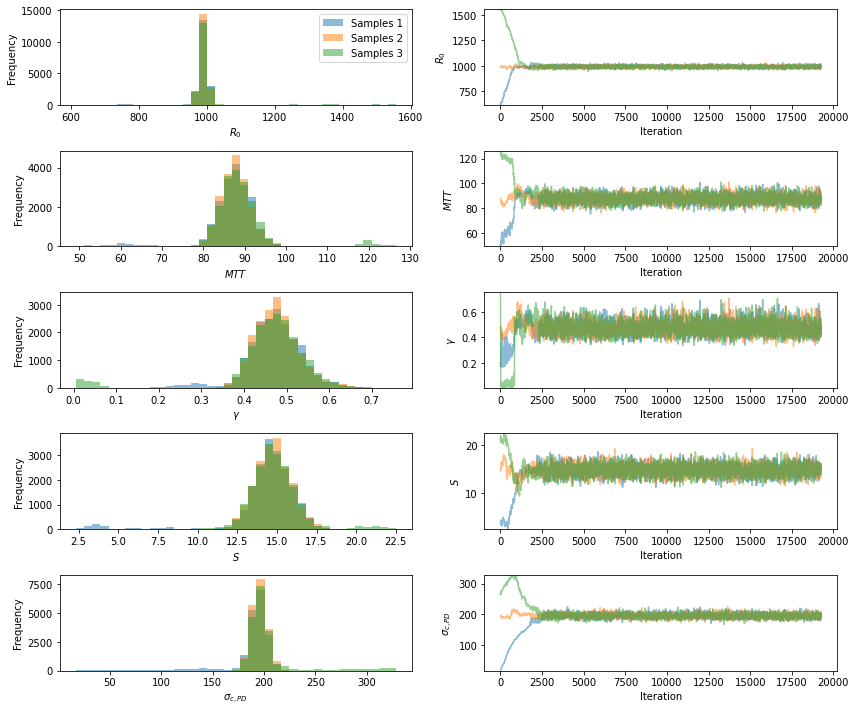

In [107]:
pints.plot.trace(samples, parameter_names=PD_param_names[:5])
# plt.savefig(image_file + "real_MCMC_add_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(samples[:,-int(0.9*num_samples):]), 
    heatmap=True,
    parameter_names=[""]*5, #PD_param_names[:5]
)
# plt.savefig(image_file + "real_MCMC_add_pairs.svg")
plt.show()

**Relative with no eta**

In [108]:
log_likelihood =  MultiplicativeGaussianLogLikelihood(problem, fix_eta=1.0)
mult_lb = np.asarray(lower_bound[:4]+lower_bound[6:])
mult_ub = np.asarray(upper_bound[:4]+upper_bound[6:])
log_prior = pints.UniformLogPrior(mult_lb, mult_ub)

# start_points = [
#     np.exp(np.log(mult_lb)*0.2+np.log(opt_mult_noeta)*0.8), 
#     opt_mult_noeta, 
#     np.exp(np.log(mult_ub)*0.2+np.log(opt_mult_noeta)*0.8)
# ]
# opt_mult_noeta = opt_mult_noeta.astype(float)
point_1 = 0.5*opt_mult_noeta
if any(point_1 <= mult_lb):
    for point_index in range(len(point_1)):
        point_1[point_index] = max(point_1[point_index], opt_mult_noeta[point_index]*0.5+0.5*mult_lb[point_index])
point_3 = 1.5*opt_mult_noeta
if any(point_3 >= mult_ub):
    for point_index in range(len(point_3)):
        point_3[point_index] = min(point_3[point_index], opt_mult_noeta[point_index]*0.5+0.5*mult_ub[point_index])
start_points = [point_1, opt_mult_noeta, point_3]
print(np.asarray(start_points))

[[4.93772982e+02 4.53154486e+01 2.57755398e-01 6.02812404e+00
  1.03696566e-01]
 [9.87545964e+02 9.06308971e+01 5.15510797e-01 1.20562481e+01
  2.07393132e-01]
 [1.48131895e+03 1.35946346e+02 7.73266195e-01 1.80843721e+01
  3.11089699e-01]]


In [38]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_real/MCMC_mult_noeta_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.12 seconds
20 	 0.4     	 0.0     	 0.4     	 nan     	 2.24 seconds
40 	 0.475     	 0.05     	 0.375     	 nan     	 4.56 seconds
60 	 0.5     	 0.0333     	 0.35     	 nan     	 6.83 seconds
80 	 0.45     	 0.0375     	 0.3125     	 nan     	 9.04 seconds
100 	 0.41     	 0.04     	 0.29     	 nan     	 11.25 seconds
120 	 0.3917     	 0.0417     	 0.3083     	 nan     	 13.48 seconds
140 	 0.35     	 0.0357     	 0.3071     	 nan     	 15.74 seconds
160 	 0.3375     	 0.0312     	 0.2938     	 nan     	 18.0 seconds
180 	 0.3444     	 0.0278     	 0.3056     	 nan     	 20.32 seconds
200 	 0.335     	 0.035     	 0.3     	 nan     	 22.62 seconds
1075 	 0.3172     	 0.0549     	 0.1693     	 nan     	 1 minute, 55 seconds
...........................
End of Initial Phase
...........................
1950 	 0.2549     	 0.0867     	 0.1441     	 nan     	 3 minutes, 21 seconds
2825 	 0.235

In [109]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_real/MCMC_mult_noeta_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_real/MCMC_mult_noeta_samples_chain', n=3))

In [110]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(samples[:,-int(0.9*num_samples):], parameter_names=np.concatenate((PD_param_names[:4],PD_param_names[6:]))).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)
df_summary = df_summary.round(decimals=4)
df_summary = pandas.DataFrame(np.insert(
    df_summary.values, 
    4, 
    values=[PD_param_names[4]] + ['.']*9, 
    axis=0
), columns = df_summary.columns)

In [111]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile'
])
df_summary_reduced['parameter'] =[
    "R_0$", 
    "MTT$", 
    "\gamma$", 
    "S$", 
    "\sigma_{c, \\textrm{PD}}$",
    "\sigma_{m, \\textrm{PD}}$"
]
fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "real_MCMC_mult_noeta_table.svg")

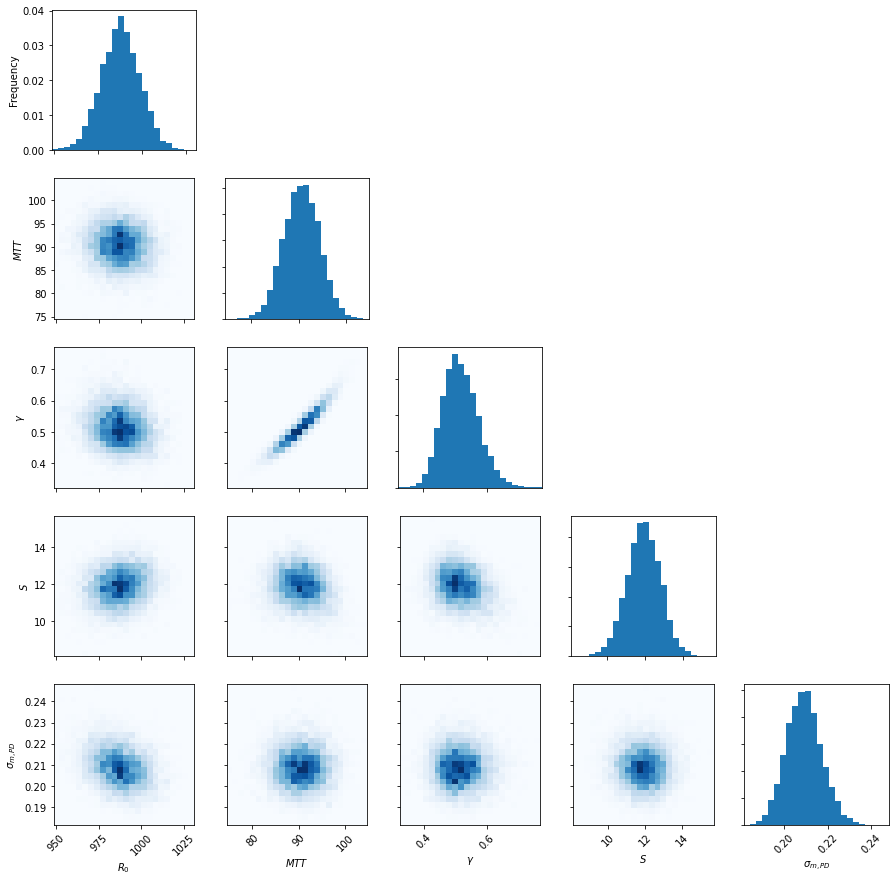

In [112]:
pints.plot.trace(np.asarray(samples), parameter_names=np.concatenate((PD_param_names[:4], PD_param_names[6:])))
# plt.savefig(image_file + "real_MCMC_mult_noeta_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(np.asarray(samples)[:,-int(0.9*num_samples):]), 
    heatmap=True,
    parameter_names=np.concatenate((PD_param_names[:4], PD_param_names[6:])),
)
# plt.savefig(image_file + "real_MCMC_mult_noeta_pairs.svg")
plt.show()

Relative Noise with Eta

In [113]:
log_likelihood =  MultiplicativeGaussianLogLikelihood(problem)
mult_lb = np.asarray(lower_bound[:4]+lower_bound[5:])
mult_ub = np.asarray(upper_bound[:4]+upper_bound[5:])

log_prior = pints.UniformLogPrior(mult_lb, mult_ub)

# start_points = [
#     np.exp(np.log(mult_lb)*0.25+np.log(opt_mult)*0.75), 
#     opt_mult, 
#     np.exp(np.log(mult_ub)*0.25+np.log(opt_mult)*0.75)
# ]

point_1 = 0.5*opt_mult
if any(point_1 <= 1.0001*mult_lb):
    for point_index in range(len(point_1)):
        point_1[point_index] = max(point_1[point_index], opt_mult[point_index]*0.5+0.5*mult_lb[point_index])
point_2 = opt_mult
if any(point_2 >= 0.9999*mult_ub):
    for point_index in range(len(point_2)):
        print(point_index, point_2[point_index], 0.75*mult_ub[point_index])
        point_2[point_index] = min(point_2[point_index], 0.75*mult_ub[point_index])
point_3 = 1.5*opt_mult
if any(point_3 >= 0.9999*mult_ub):
    for point_index in range(len(point_3)):
        point_3[point_index] = min(point_3[point_index], point_2[point_index]*0.75+0.25*mult_ub[point_index])

start_points = [point_1, point_2, point_3]

print(np.asarray(start_points))

0 989.6957058213698 7044.0
1 89.49448559848074 414.0
2 0.4981542614602727 3.75
3 12.84506263083174 75.0
4 0.7705138571069339 7.5
5 0.9899999999999938 0.7424999999999999
[[4.94847853e+02 4.47472428e+01 2.49077131e-01 6.42253132e+00
  3.85256929e-01 4.95000000e-01]
 [9.89695706e+02 8.94944856e+01 4.98154261e-01 1.28450626e+01
  7.70513857e-01 7.42500000e-01]
 [1.48454356e+03 1.34241728e+02 7.47231392e-01 1.92675939e+01
  1.15577079e+00 8.04375000e-01]]


In [115]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_real/MCMC_mult_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.25 seconds
20 	 0.3     	 0.1     	 0.15     	 nan     	 4.99 seconds
40 	 0.3     	 0.075     	 0.075     	 nan     	 10.02 seconds
60 	 0.2333     	 0.0667     	 0.0833     	 nan     	 15.05 seconds
80 	 0.225     	 0.05     	 0.075     	 nan     	 19.95 seconds
100 	 0.21     	 0.04     	 0.06     	 nan     	 24.8 seconds
120 	 0.1833     	 0.0333     	 0.0667     	 nan     	 29.69 seconds
140 	 0.1714     	 0.0286     	 0.0714     	 nan     	 34.68 seconds
160 	 0.1688     	 0.025     	 0.0625     	 nan     	 39.73 seconds
180 	 0.1611     	 0.0278     	 0.0611     	 nan     	 44.72 seconds
200 	 0.16     	 0.025     	 0.065     	 nan     	 49.68 seconds
Error for parameters: [5.35424454e+02 4.76574377e+01 1.57632057e-01 8.12948973e+00
 8.60191295e-01 8.94023774e-01]


KeyboardInterrupt: 

In [116]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_real/MCMC_mult_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_real/MCMC_mult_samples_chain', n=3))

In [117]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(
        samples[:,-num_samples:], 
        parameter_names=np.concatenate((PD_param_names[:4],PD_param_names[5:]))
    ).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)
df_summary = df_summary.round(decimals=4)
df_summary = pandas.DataFrame(np.insert(
    df_summary.values, 
    4, 
    values=[PD_param_names[4]] + ['.']*9, 
    axis=0
), columns = df_summary.columns)

In [119]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile',
])

fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "real_MCMC_mult_table.svg")

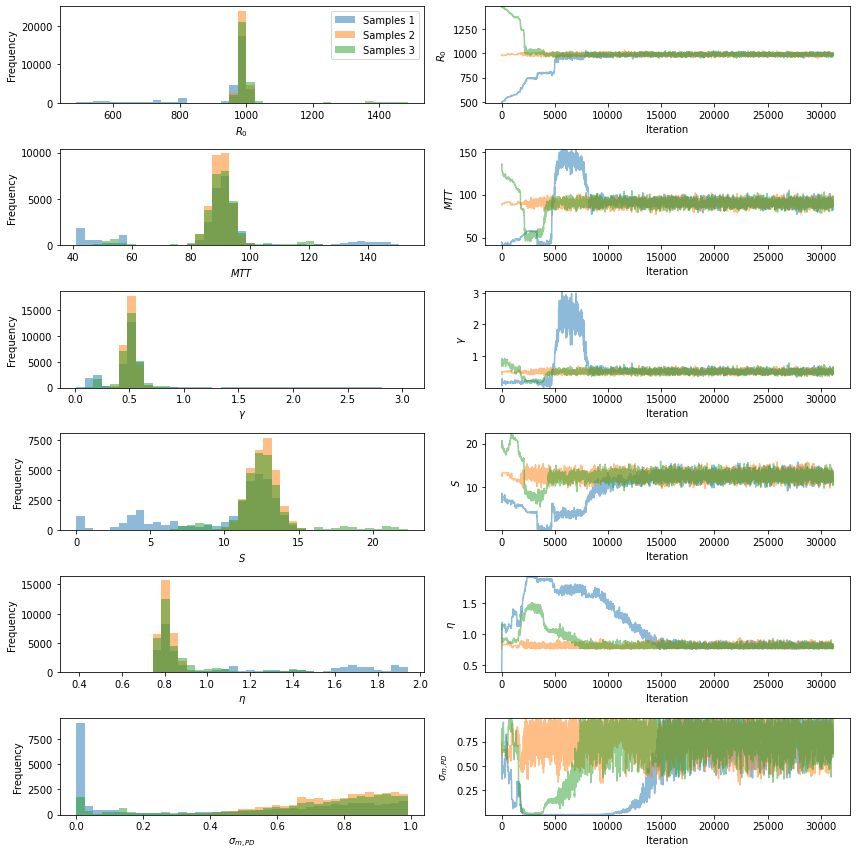

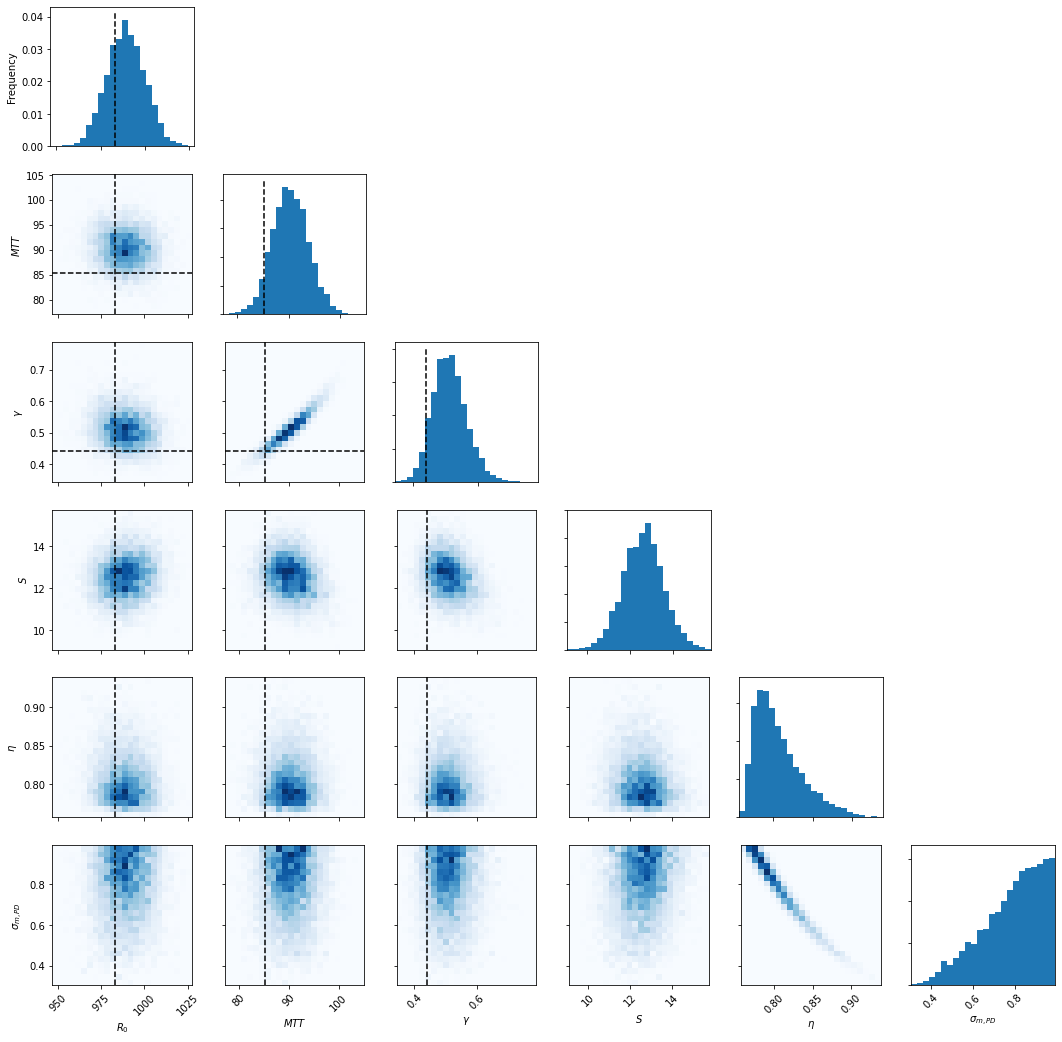

In [120]:
pints.plot.trace(np.asarray(samples), parameter_names=np.concatenate((PD_param_names[:4], PD_param_names[5:])))
# plt.savefig(image_file + "real_MCMC_mult_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(np.asarray(samples)[:,-int(0.9*num_samples):]), 
    heatmap=True,
    ref_parameters=np.concatenate((PD_actual_params[:4], PD_actual_params[5:])),
    parameter_names=np.concatenate((PD_param_names[:4], PD_param_names[5:])),
)
# plt.savefig(image_file + "real_MCMC_mult_pairs.svg")
plt.show()

Combined Noise with fixed eta

In [121]:
log_likelihood =  ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=[None, 1, None])
comb_lb = np.asarray(lower_bound[:5]+lower_bound[6:])
comb_ub = np.asarray(upper_bound[:5]+upper_bound[6:])
log_prior = pints.UniformLogPrior(comb_lb, comb_ub)

start_points = [
    np.exp(np.log(comb_lb)*0.25+0.75*np.log(opt_comb_noeta)), 
    opt_comb_noeta, 
    np.exp(np.log(comb_ub)*0.25+0.75*np.log(opt_comb_noeta))]
print(np.asarray(start_points))

[[5.49567160e+02 4.37067872e+01 1.49874675e-01 2.41657852e+00
  9.20102606e+00 1.00000000e-03]
 [9.90318753e+02 8.71135046e+01 4.65565728e-01 1.50522428e+01
  1.92803545e+02 1.00000000e-03]
 [1.73788395e+03 1.38212997e+02 8.42807232e-01 2.41657852e+01
  2.86434801e+02 5.60930169e-03]]


In [36]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_real/MCMC_comb_noeta_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.12 seconds
20 	 0.25     	 0.0     	 0.55     	 nan     	 2.3 seconds
40 	 0.4     	 0.0     	 0.575     	 nan     	 4.57 seconds
Error for parameters: [1.68780532e+03 1.34976259e+02 8.99130692e-02 2.40022669e+01
 2.84910953e+02 1.11369460e-01]


KeyboardInterrupt: 

In [123]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_real/MCMC_comb_noeta_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_real/MCMC_comb_noeta_samples_chain', n=3))

In [124]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(
        samples[:,-num_samples:], 
        parameter_names=np.concatenate((PD_param_names[:5],PD_param_names[6:]))
    ).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)
df_summary = df_summary.round(decimals=4)
df_summary = pandas.DataFrame(np.insert(
    df_summary.values, 
    5, 
    values=[PD_param_names[5]] + ['.']*9, 
    axis=0
), columns = df_summary.columns)

In [126]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile',
])

fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "real_MCMC_comb_noeta_table.svg")

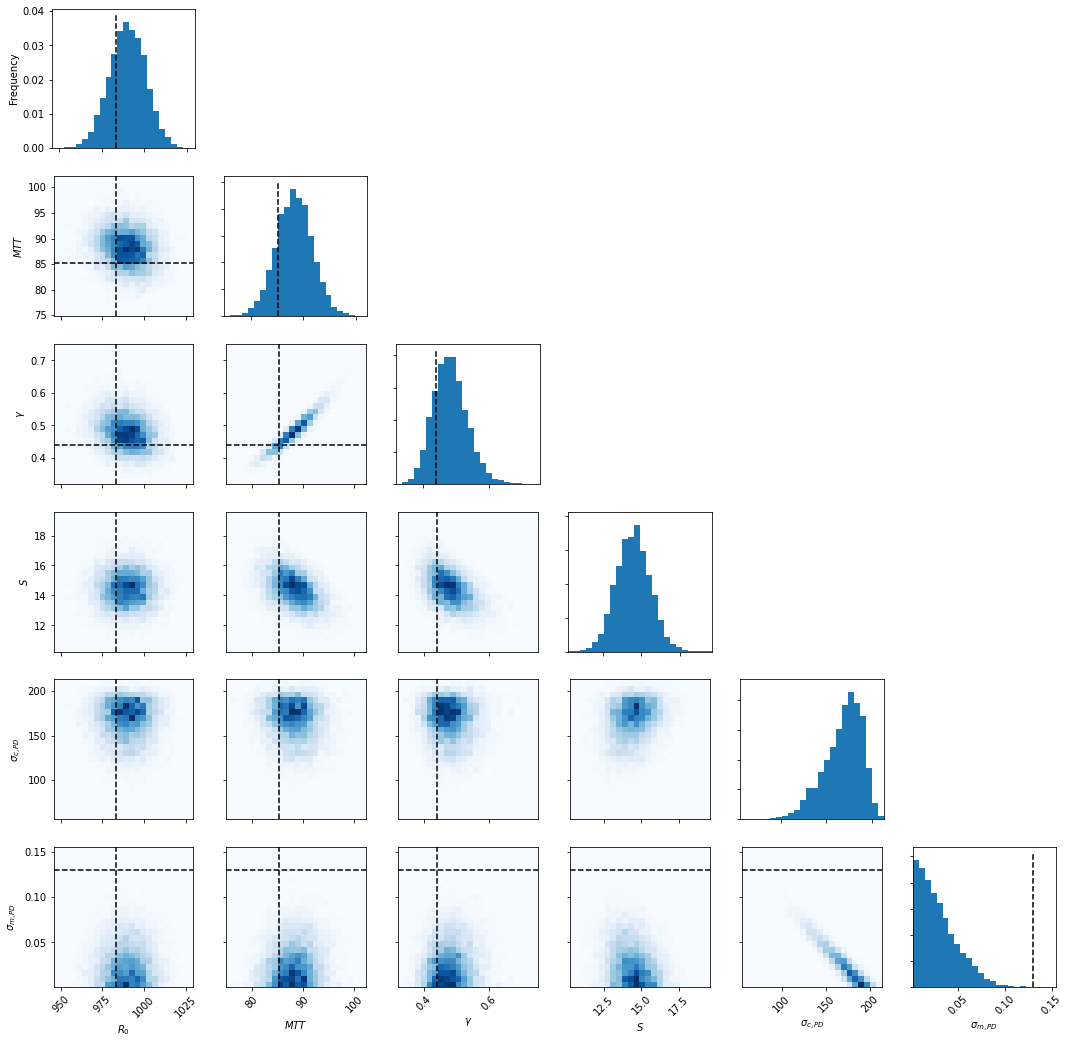

In [127]:
pints.plot.trace(samples, parameter_names=np.concatenate((PD_param_names[:5],PD_param_names[6:])))
# plt.savefig(image_file + "real_MCMC_comb_noeta_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(samples[:,-num_samples:]), 
    heatmap=True,
    ref_parameters=np.concatenate((PD_actual_params[:5],PD_actual_params[6:])),
    parameter_names=np.concatenate((PD_param_names[:5],PD_param_names[6:])),
)
# plt.savefig(image_file + "real_MCMC_comb_noeta_pairs.svg")
plt.show()

Combined Noise with eta

In [128]:
log_likelihood =  ConstantAndMultiplicativeGaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(lower_bound, upper_bound)

start_points = [
    np.exp(np.log(lower_bound)*0.25+0.75*np.log(opt_comb)), 
    opt_comb, 
    np.exp(np.log(upper_bound)*0.25+0.75*np.log(opt_comb))]
print(np.asarray(start_points))

[[5.49259215e+02 4.40852681e+01 1.53490386e-01 2.38302435e+00
  9.21102958e+00 1.52484209e-01 1.04666718e-03]
 [9.89578934e+02 8.81207713e+01 4.80601258e-01 1.47742227e+01
  1.93083088e+02 8.14641436e-01 1.06270195e-03]
 [1.73691015e+03 1.39409859e+02 8.63139871e-01 2.38302435e+01
  2.86746218e+02 1.52484209e+00 5.87107199e-03]]


In [39]:
samples = MCMC_run(
    log_likelihood, 
    log_prior, 
    start_points, 
    num_iterations, 
    num_samples, 
    save_point_like='../Data_and_parameters/PD_real/MCMC_comb_pointloglike_chain'
)

iter 	 chain 0 	 chain 1 	 chain 2 	 R_hat 		 Time
1 	 0.0     	 0.0     	 0.0     	 nan     	 0.12 seconds


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/Notebooks/Code/Likelihoods.py:267: RuntimeWarning: invalid value encountered in log
  np.log(sigma_tot) -


20 	 0.25     	 0.0     	 0.1     	 nan     	 2.23 seconds
40 	 0.3     	 0.025     	 0.125     	 nan     	 4.39 seconds
60 	 0.3167     	 0.0667     	 0.1     	 nan     	 6.57 seconds
Error for parameters: [9.79396173e+02 9.47001841e+01 5.60280194e-01 1.42799441e+01
 1.93471974e+02 8.00713007e-01 8.11874928e-03]


KeyboardInterrupt: 

In [129]:
# for chain, sample_chain in enumerate(samples):
#     pints.io.save_samples('../Data_and_parameters/PD_real/MCMC_comb_samples_chain'+"_"+str(chain), sample_chain)

samples = np.asarray(pints.io.load_samples('../Data_and_parameters/PD_real/MCMC_comb_samples_chain', n=3))

In [130]:
df_summary = pandas.DataFrame(
    pints.MCMCSummary(samples[:,-num_samples:], parameter_names=PD_param_names).summary(), 
    columns = [
        'parameter',
        'mean',
        'std deviation',
        '2.5% quantile',
        '25% quantile',
        '50% quantile', 
        '75% quantile', 
        '97.5% quantile', 
        'rhat', 
        'ess',
    ]
)

df_summary = df_summary.round(decimals=4)

In [131]:
fig =  ff.create_table(df_summary)
fig.update_layout(
    width=1000,
    height=200,
)
fig.show()

df_summary_reduced = df_summary.drop(columns=[
    '2.5% quantile',
    '25% quantile',
    '50% quantile', 
    '75% quantile', 
    '97.5% quantile'
])

fig =  ff.create_table(df_summary_reduced)
fig.update_layout(
    width=500*5/6.0,
    height=200,
)
# fig.write_image(image_file + "real_MCMC_comb_table.svg")

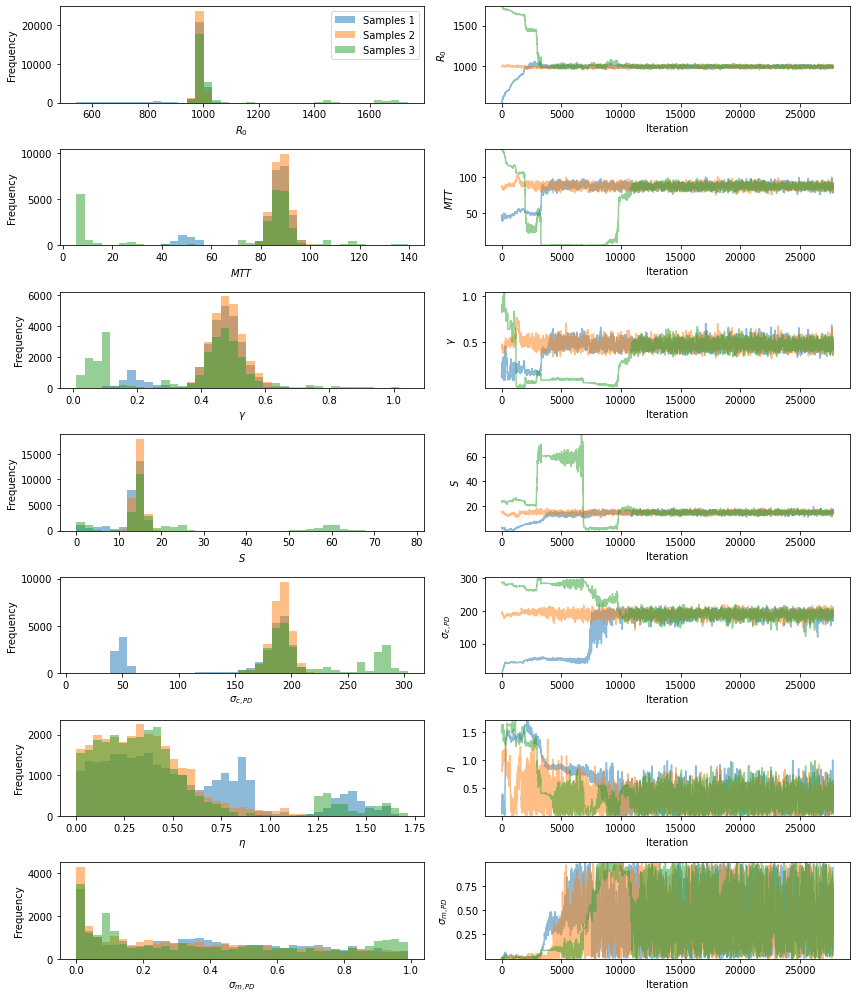

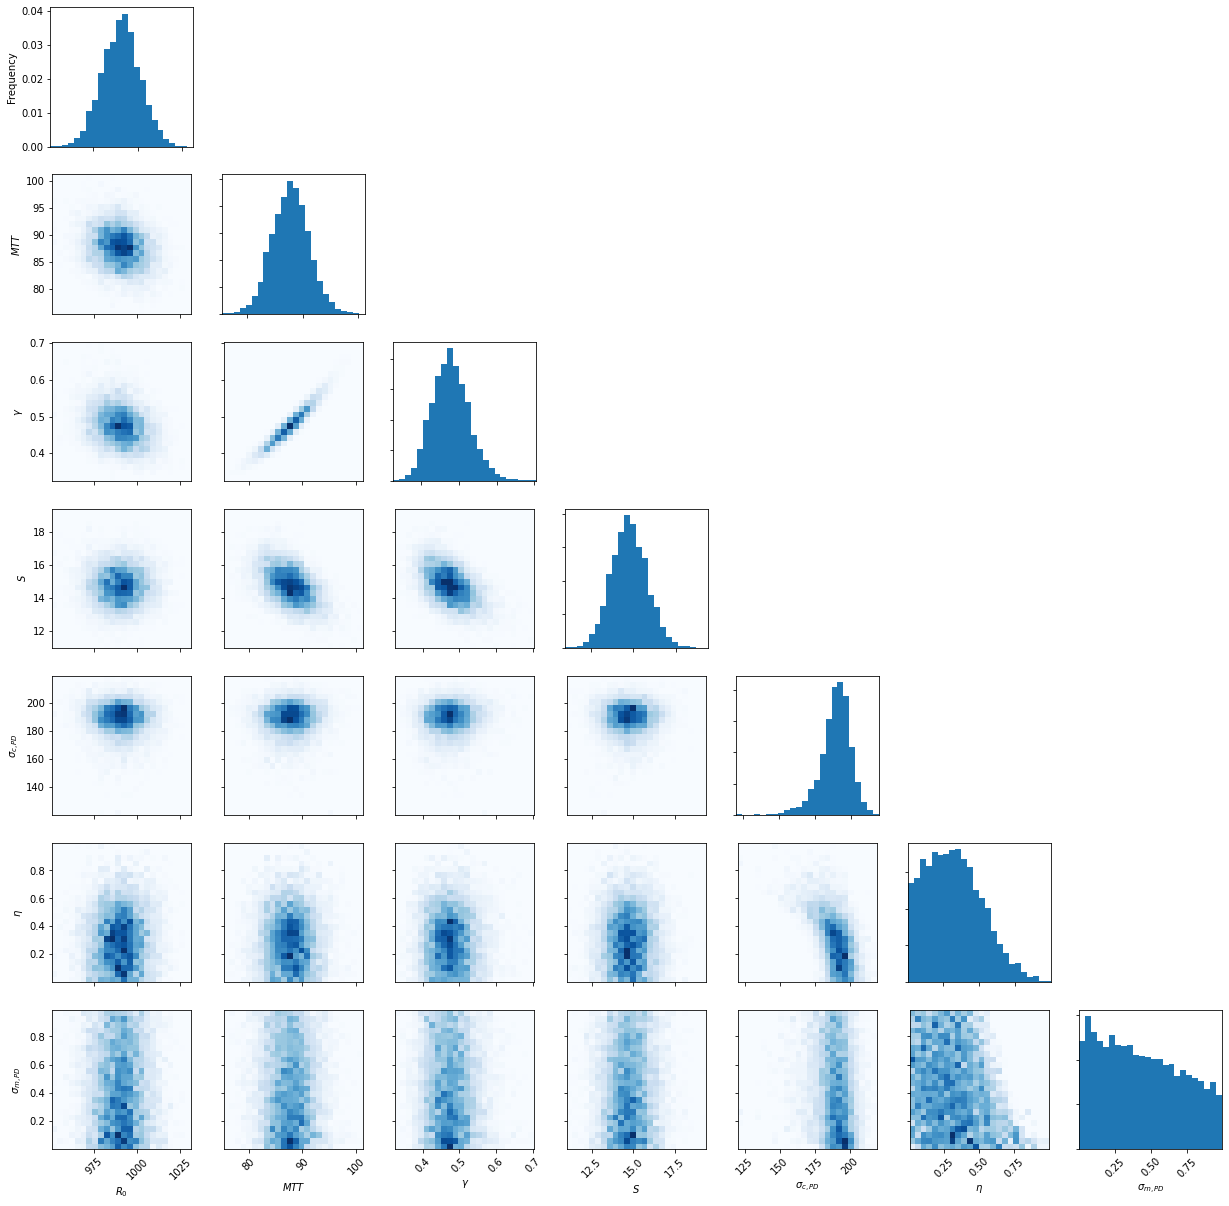

In [132]:
pints.plot.trace(samples, parameter_names=PD_param_names)
# plt.savefig(image_file + "real_MCMC_comb_trace.svg")
plt.show()
pints.plot.pairwise(
    np.vstack(samples[:,-int(0.9*num_samples):]), 
    heatmap=True,
    parameter_names=PD_param_names,
)
# plt.savefig(image_file + "real_MCMC_comb_pairs.svg")
plt.show()

Next Notebook: [Parameter Identifiability](5_parameter_identifiability_naive.ipynb)